In [ ]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter,filtfilt
import scipy.signal as sg
import plotly as py
import plotly.graph_objs as go
from plotly import tools
from scipy.fftpack import fft, ifft
from plotly.subplots import make_subplots

py.offline.init_notebook_mode(connected=True)

%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
#preprocessors

import scipy.io as sio

import mne
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import CSP




def inputmat(fp):
    """load .mat file and return m as a dict"""
    mat = sio.loadmat(fp, squeeze_me=True)
    td = {}  # create a dict

    # Numpy array of size channel_num * points.
    td['data'] = mat['cnt'].T  # data
    td['freq'] = mat['nfo']['fs'][True][0]  # Sampling frequency

    # channel names are necessary information for creating a rawArray.
    td['ch_names'] = mat['nfo']['clab'][True][0]

    # Position of channels
    
    td['electrode_x'] = mat['nfo']['xpos'][True][0]
    td['electrode_y'] = mat['nfo']['ypos'][True][0]

    #make trials by finding trials and its data
    td['cue'] = mat['mrk']['pos'][True][0] #time of cue
    td['labels'] = mat['mrk']['y'][True][0] #labels of the data
    return td


def creatEventsArray(fp):
    """Create events array. The second column default to zero."""
    td = inputmat(fp)
    events = np.zeros((td['labels'].size, 3), int) #here we have made a matrix type array of the size of label.size*3
#     print(events)
    events[:, 0] = td['cue']  # The first column is the sample number of the event.
#     print(events[:, 0])
    events[:, 2] = td['labels']  # The third column is the new event value.
#     print(events[:, 2])
    return events, td['labels']


def creatRawArray(fp):
    """Create a mne.io.RawArray object, data: array, shape (n_channels, n_times)"""
    td = inputmat(fp)
    ch_names = td['ch_names'].tolist()
    info = mne.create_info(ch_names, td['freq'], 'eeg')  # Create info for raw
    raw = mne.io.RawArray(td['data'], info, first_samp=0, copy='auto', verbose=None)
    return raw


In [ ]:
# Where to save the figures

"""
image relation with dpi and resolution

https://stackoverflow.com/questions/47633546/relationship-between-dpi-and-figure-size

"""

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification_png_ex"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=660):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

from mne.decoding import CSP
from mne.channels import read_layout

In [10]:
"""The files c, d, e are the artificial data so we can test out our labels in different ways in them"""


file1 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat'
file2 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1b_1000Hz.mat'

# artificial data files

file3 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1c_1000Hz.mat'
file4 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1d_1000Hz.mat'
file5 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1e_1000Hz.mat'
file6 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1f_1000Hz.mat'
file7 = r'Data/BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1g_1000Hz.mat'



"""making the file dictionary and channel dictionary for easy pickup"""
fp = {
    'ds1a': file1,
    'ds1b': file2,
    'ds1f': file6,
    'ds1g': file7,
}


#     'ds1c': file3, #these three are artificial datatsets
#     'ds1d': file4,
#     'ds1e': file5,

""" Pick channels if necessary but not needed as we will be deploying a CSP pipeline ahead"""

# pick_chan = {
#     'ds1a': ['C3', 'Cz', 'C5'],
#     'ds1b': ['C3', 'Cz', 'C5'],
#     'ds1c': ['C3', 'Cz', 'C5'],  
#     'ds1d': ['C3', 'Cz', 'C5'],
#     'ds1e': ['C3', 'Cz', 'C5'],
#     'ds1f': ['C3', 'Cz', 'C5'],
#     'ds1g': ['C3', 'Cz', 'C5'],
# }

low_freq, high_freq = 7., 30.
tmin, tmax = 0., 3.5

# event_id
# event_id = {'right': 1, 'foot': 2}
#changing eventid from right to left
event_id = {'left': -1, 'foot': 1}

In [11]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [12]:
def adjustedR2(r2,n,k=3):
    return r2-(k-1)/(n-k)*(1-r2)

In [13]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50, 150, 0, 1])   

In [17]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    #plt.xlabel('Flase positive Rate (Fall-out)', Fontsize=16)
    #plt.ylabel('True positive Rate (Recall)', Fontsize=16)
    plt.grid(True)

In [15]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
__________________________________________________________________________
labels:  [ 1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1
  1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1
  1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1 -1
  1 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1 -1 -1 -1
 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1
 -1  1 -1 -1 -1  1  1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.9s


__________________________________________________________________________
labels after band pass filter:  [ 1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1
  1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1 -1
  1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1
  1  1 -1  1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1 -1
  1 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1 -1 -1 -1
 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1  1 -1
 -1  1 -1 -1 -1  1  1  1]
__________________________________________________________________________
__________________________________________________________________________
labels after epochs.events change:  [ 1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1

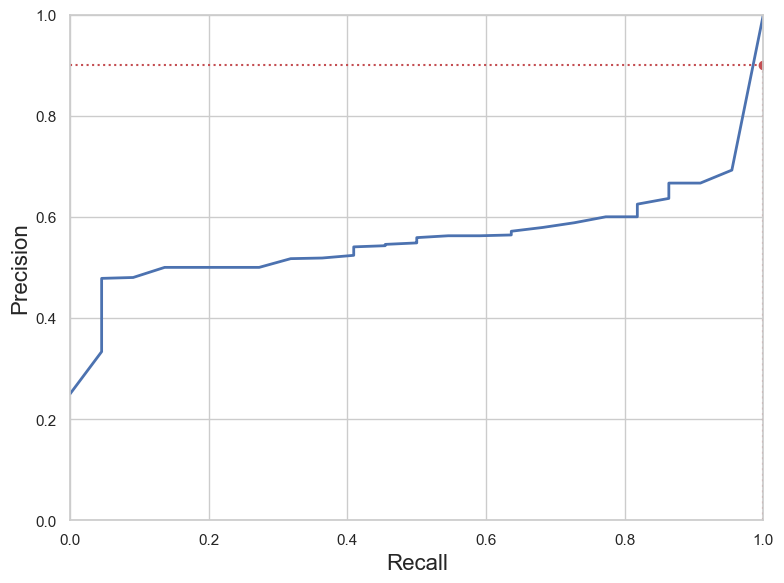

Saving figure LDA_classifier_roc_curve_ds1a


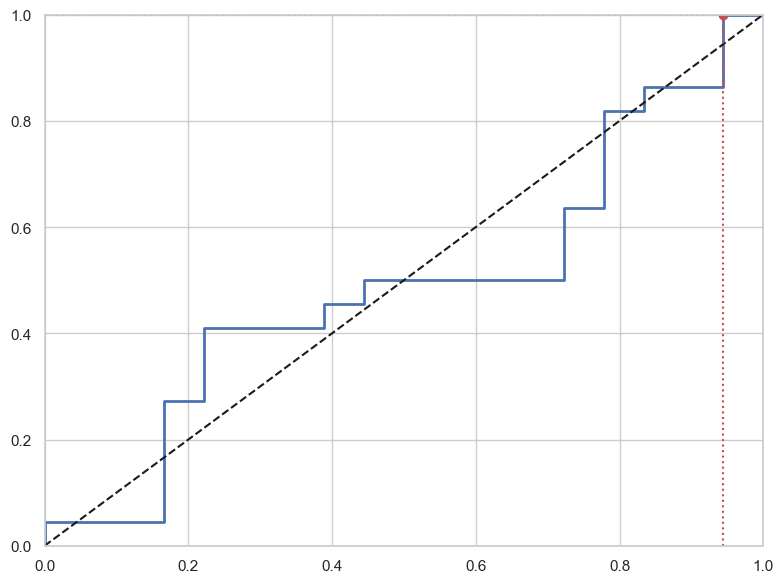

This is the roc_auc_score 0.5463659147869674
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
__________________________________________________________________________
labels:  [ 1 -1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1  1
  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1 -1
  1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1
 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1
 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1
  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1  1  1
 -1 -1  1  1 -1  1  1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


__________________________________________________________________________
labels after band pass filter:  [ 1 -1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1  1
  1 -1  1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1 -1
  1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1 -1  1 -1 -1
 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1
 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1 -1  1
  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1  1  1
 -1 -1  1  1 -1  1  1  1]
__________________________________________________________________________
__________________________________________________________________________
labels after epochs.events change:  [ 1 -1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1

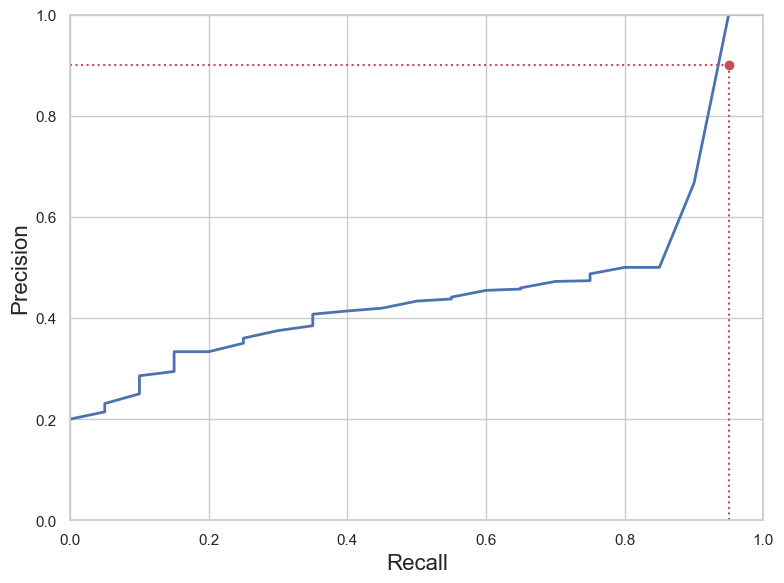

Saving figure LDA_classifier_roc_curve_ds1b


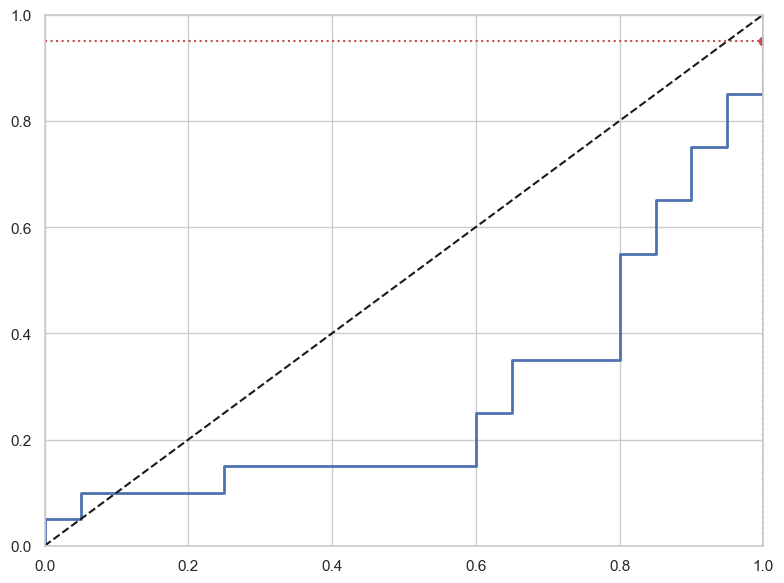

This is the roc_auc_score 0.53125
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
__________________________________________________________________________
labels:  [-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1
  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1
  1  1 -1 -1  1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1
 -1 -1 -1  1  1 -1 -1  1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1
  1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1
  1  1  1 -1  1  1 -1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up band-pass 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s


__________________________________________________________________________
labels after band pass filter:  [-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1
  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1
  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1
  1  1 -1 -1  1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1  1
 -1 -1 -1  1  1 -1 -1  1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1
  1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1
  1  1  1 -1  1  1 -1  1]
__________________________________________________________________________
__________________________________________________________________________
labels after epochs.events change:  [-1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1
  1 -1 -1 -1 -1  1  1 -1

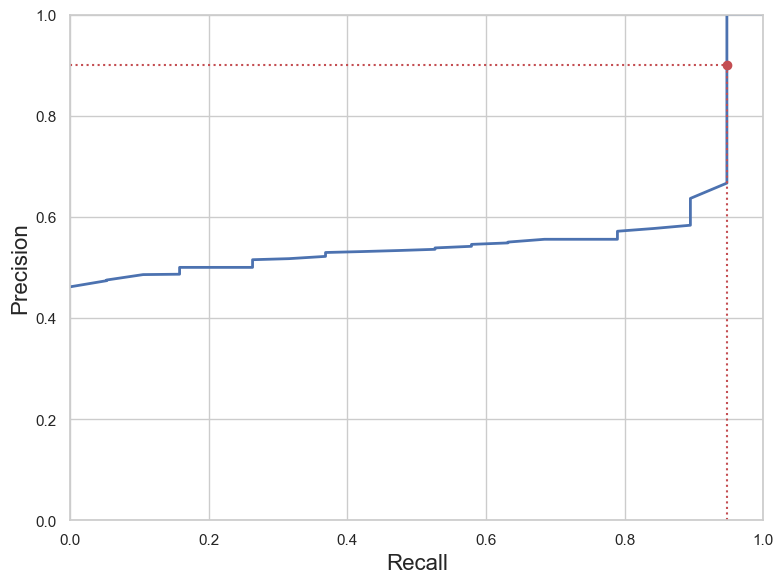

Saving figure LDA_classifier_roc_curve_ds1f


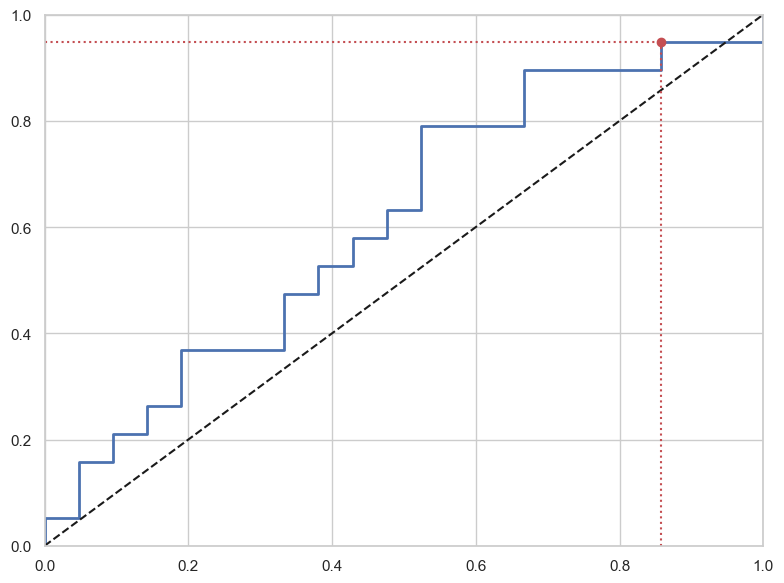

This is the roc_auc_score 0.4782608695652174
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
__________________________________________________________________________
labels:  [ 1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1
 -1 -1  1  1  1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1 -1 -1  1 -1
 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1  1 -1 -1 -1
 -1  1  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1  1 -1  1 -1 -1  1 -1
 -1  1  1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1  1
  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1
 -1 -1 -1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1
  1 -1 -1 -1 -1 -1  1  1]
__________________________________________________________________________
Filtering raw data in 1 contiguous segment
Setting up

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


__________________________________________________________________________
labels after band pass filter:  [ 1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1
 -1 -1  1  1  1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1 -1 -1  1 -1
 -1 -1 -1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1  1 -1 -1 -1
 -1  1  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1  1 -1  1 -1 -1  1 -1
 -1  1  1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1  1
  1 -1  1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1 -1
 -1 -1 -1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1
  1 -1 -1 -1 -1 -1  1  1]
__________________________________________________________________________
__________________________________________________________________________
labels after epochs.events change:  [ 1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1 -1
 -1 -1  1  1  1 -1 -1  1

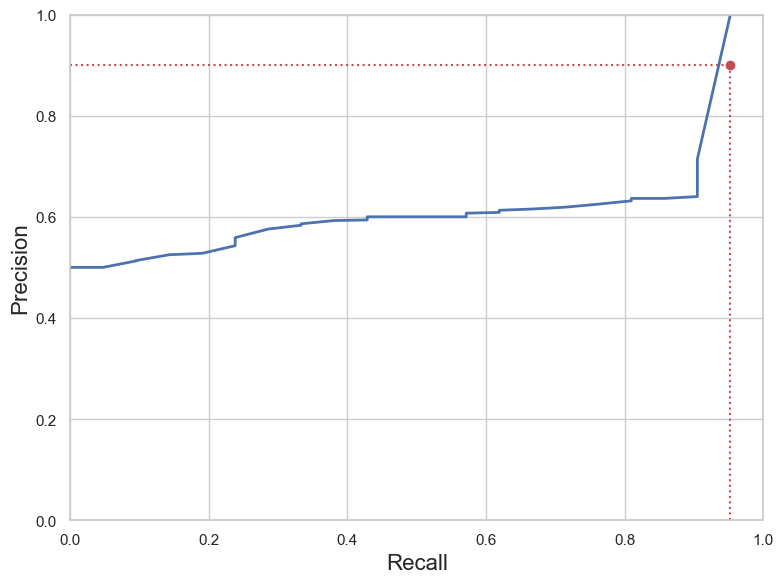

Saving figure LDA_classifier_roc_curve_ds1g


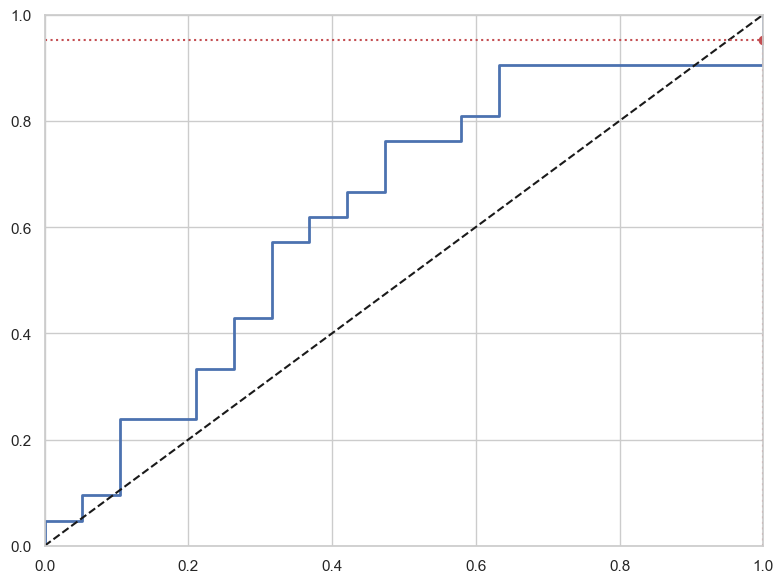

This is the roc_auc_score 0.6239999999999999


In [18]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html
This is the LDA classifier pipeline

"""


for f in fp: #for each file in the file dictionary
    raw = creatRawArray(fp[f])  #
    events, labels = creatEventsArray(fp[f])
    
    print('__________________________________________________________________________')
    print('labels: ', labels)
    print('__________________________________________________________________________')
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')

    # event_train = eventsTrain(fp[f])
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    print('__________________________________________________________________________')
    print('labels after band pass filter: ', labels)
    print('__________________________________________________________________________')

    # labels = epochs.events[:, -1] - 2
    labels = epochs.events[:, -1]


    print('__________________________________________________________________________')
    print('labels after epochs.events change: ', labels)
    print('__________________________________________________________________________')

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    # CSP is common spatial pattern, it is a spatial filter to enhance the EEG for discriminating two conditions
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)

    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')
    
#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_test_dfs = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='decision_function')

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "LDA_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "LDA_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


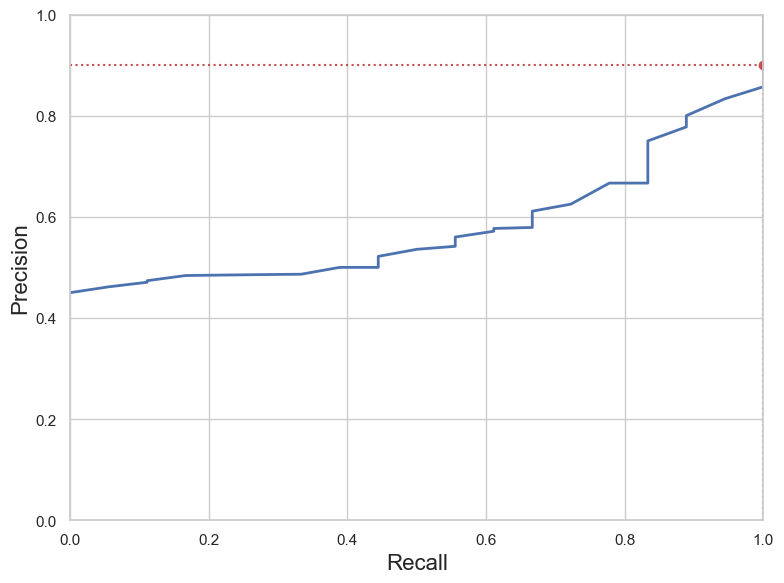

Saving figure SVM_classifier_roc_curve_ds1a


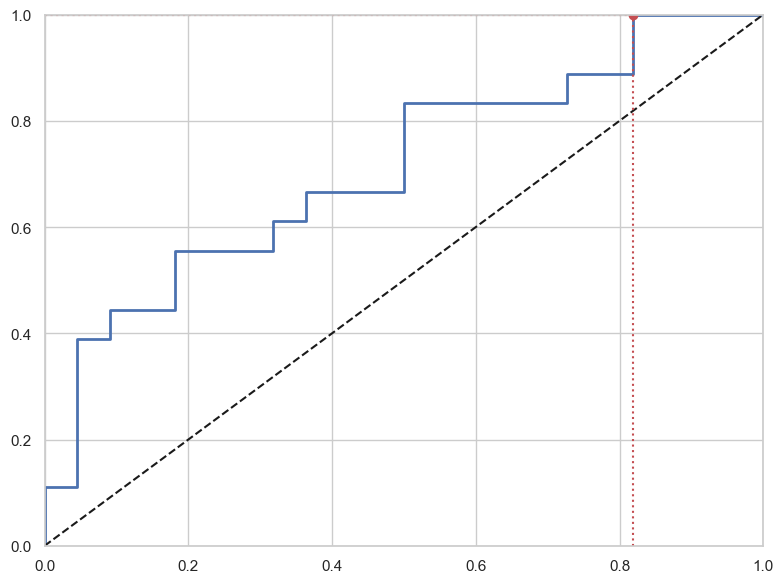

This is the roc_auc_score 0.6565656565656566
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

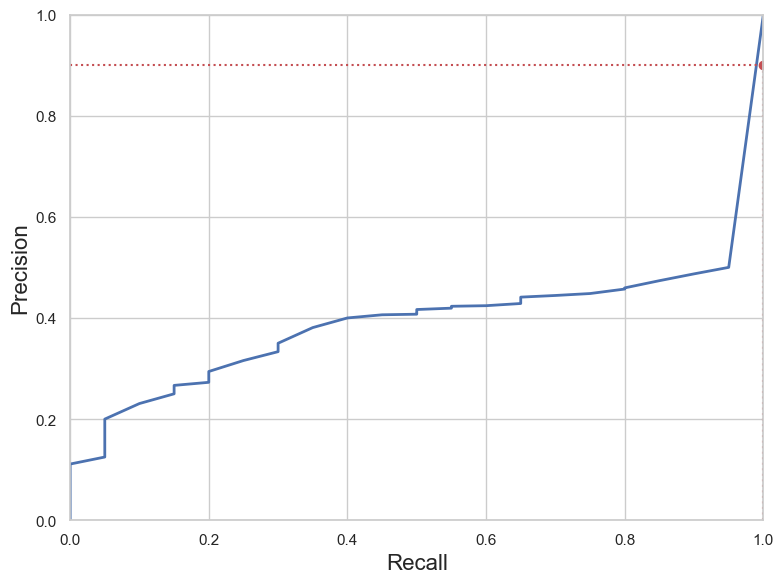

Saving figure SVM_classifier_roc_curve_ds1b


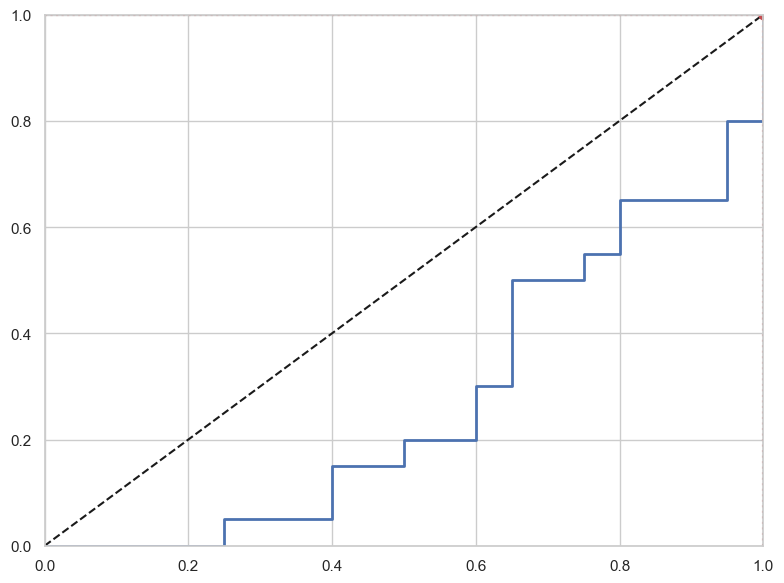

This is the roc_auc_score 0.6785714285714286
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


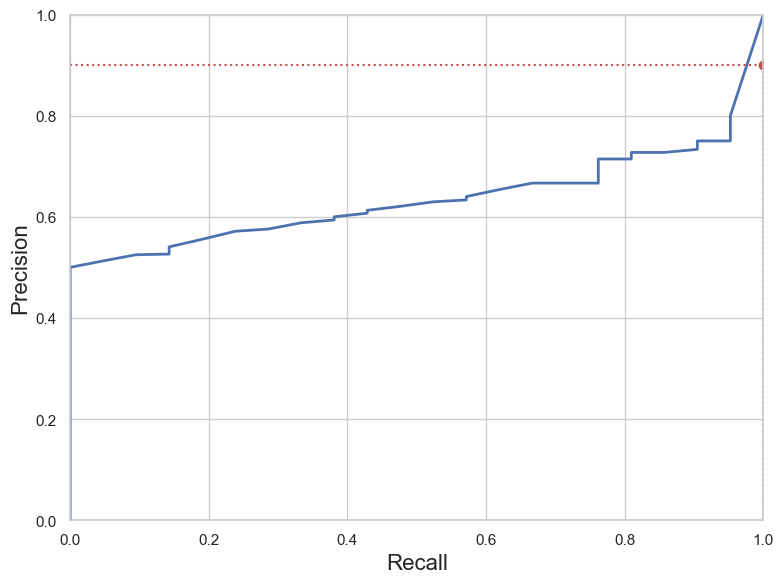

Saving figure SVM_classifier_roc_curve_ds1f


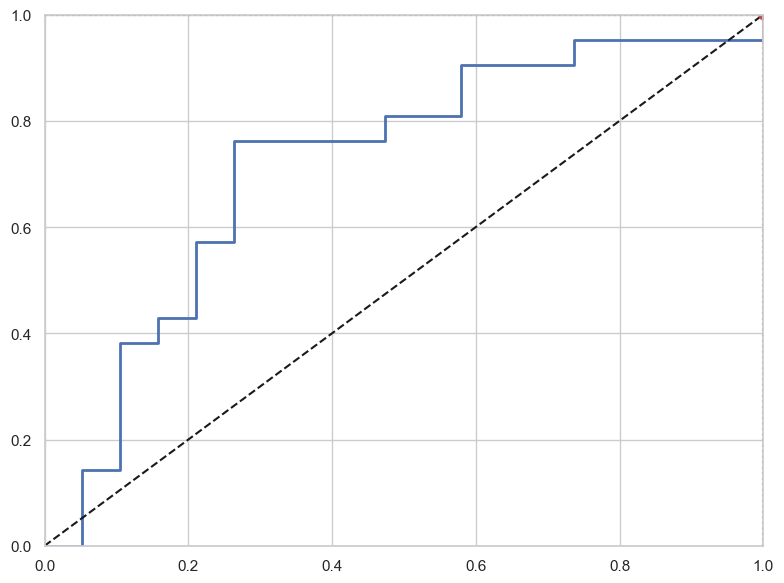

This is the roc_auc_score 0.6165413533834587
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


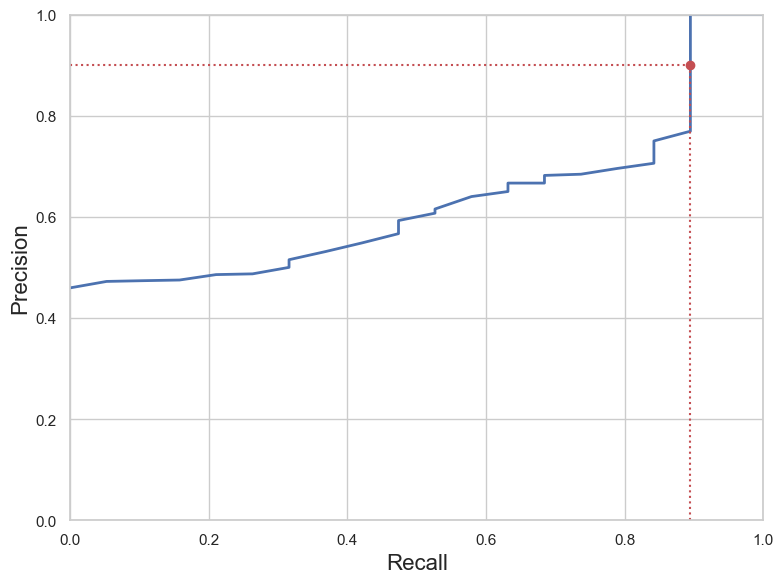

Saving figure SVM_classifier_roc_curve_ds1g


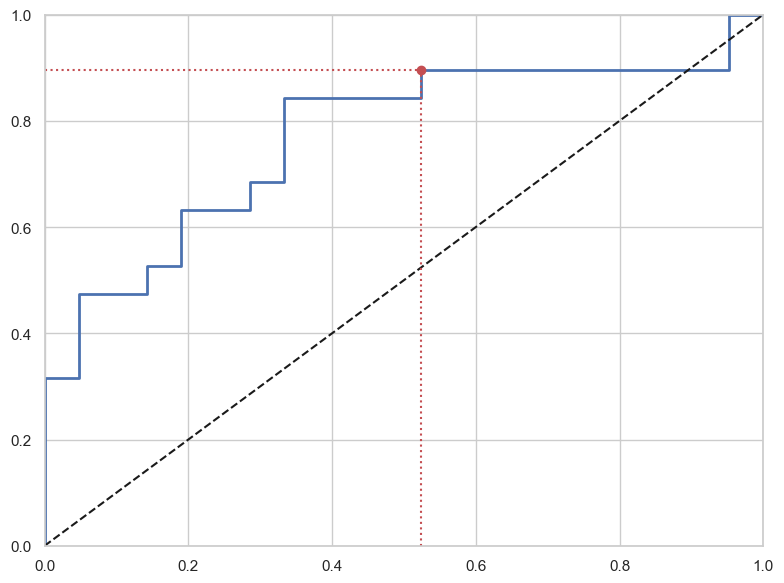

This is the roc_auc_score 0.7263427109974425


In [19]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the SVM classifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from mne.decoding import Scaler

for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    

    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    SVM_C = svm.SVC(kernel='rbf', degree=100)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('SVM_C', SVM_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_test_dfs = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='decision_function')

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "SVM_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "SVM_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


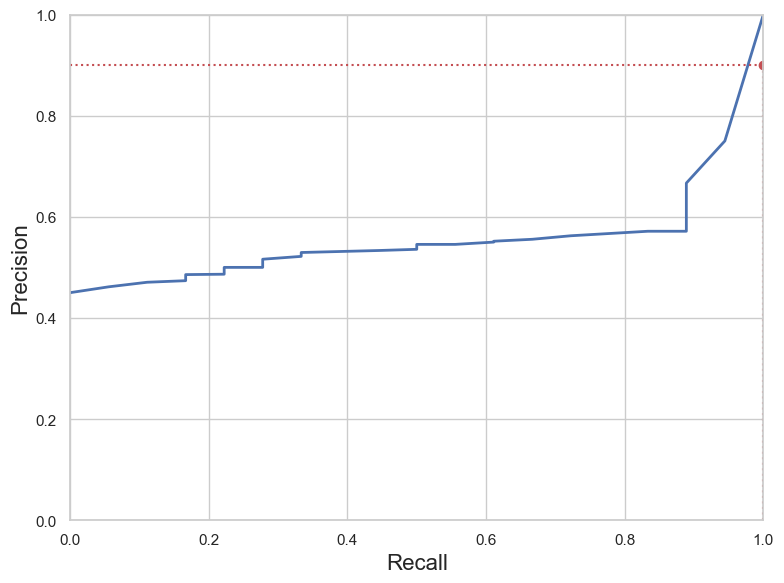

Saving figure Random_forest_classifier_roc_curve_ds1a


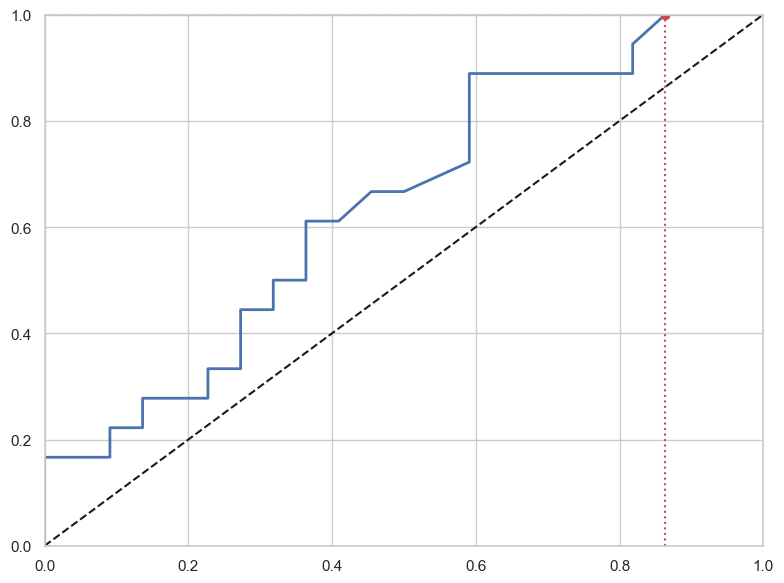

This is the roc_auc_score 0.6240601503759399
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

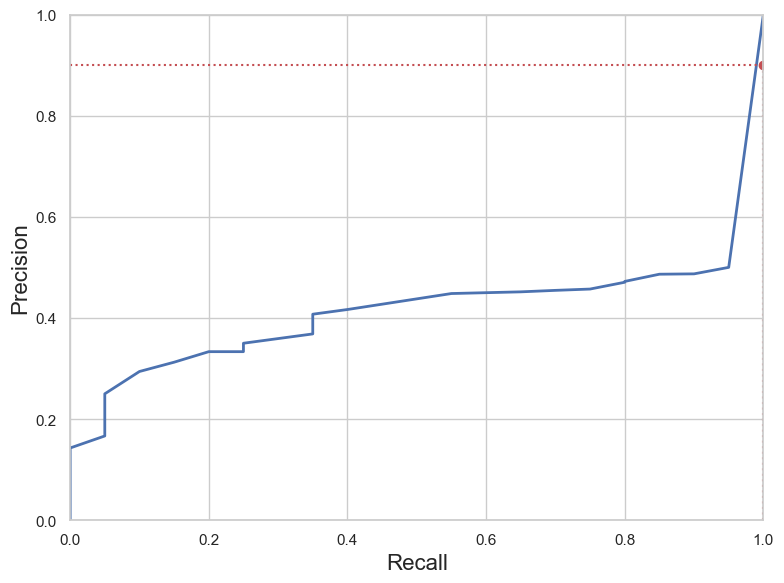

Saving figure Random_forest_classifier_roc_curve_ds1b


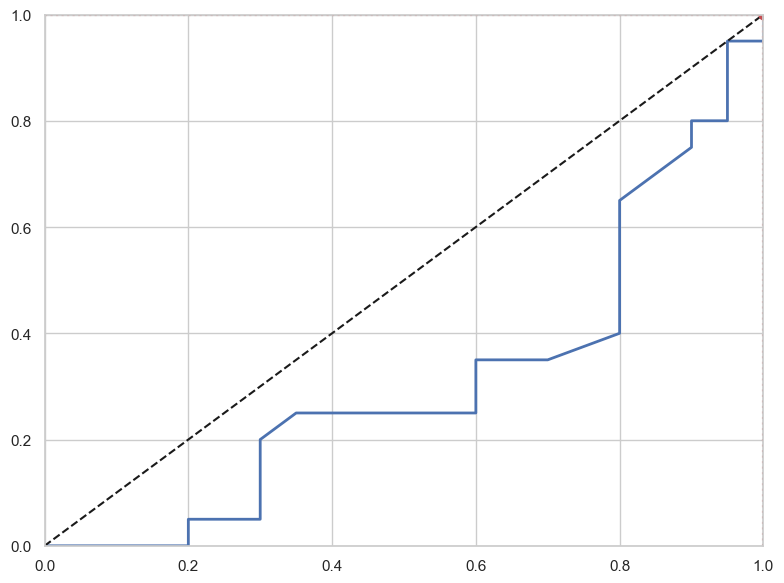

This is the roc_auc_score 0.5549872122762148
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


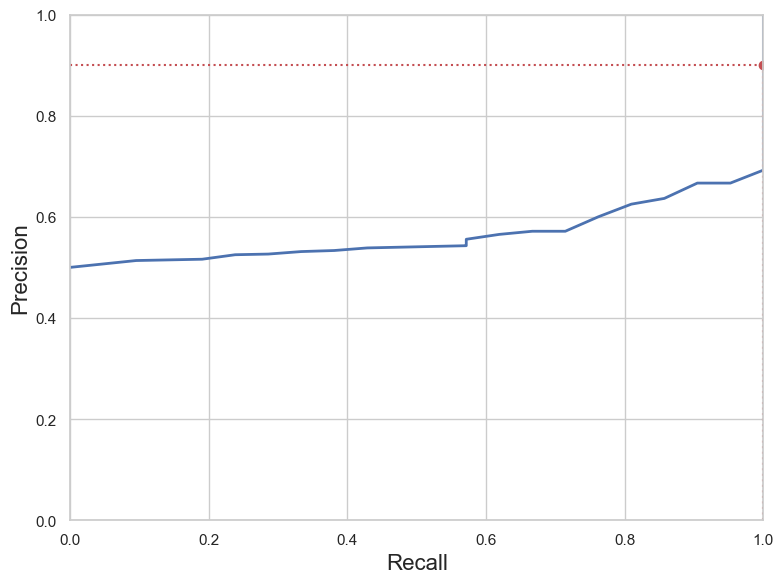

Saving figure Random_forest_classifier_roc_curve_ds1f


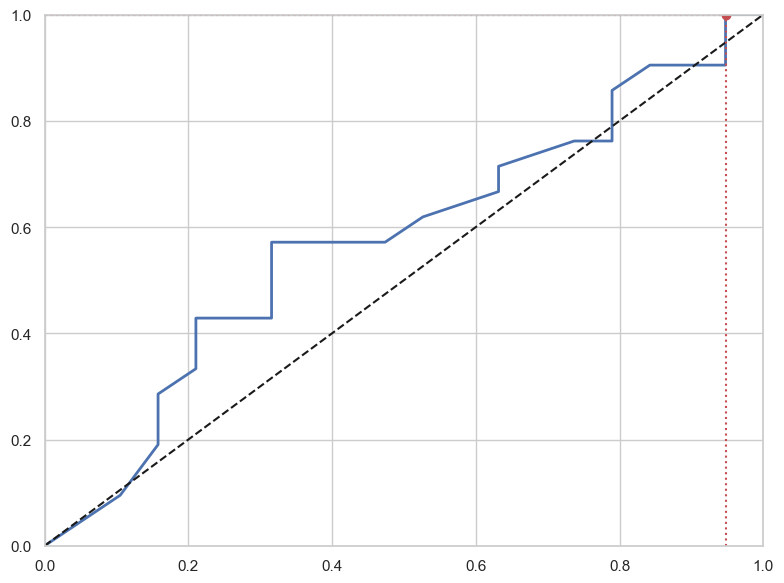

This is the roc_auc_score 0.6954887218045113
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


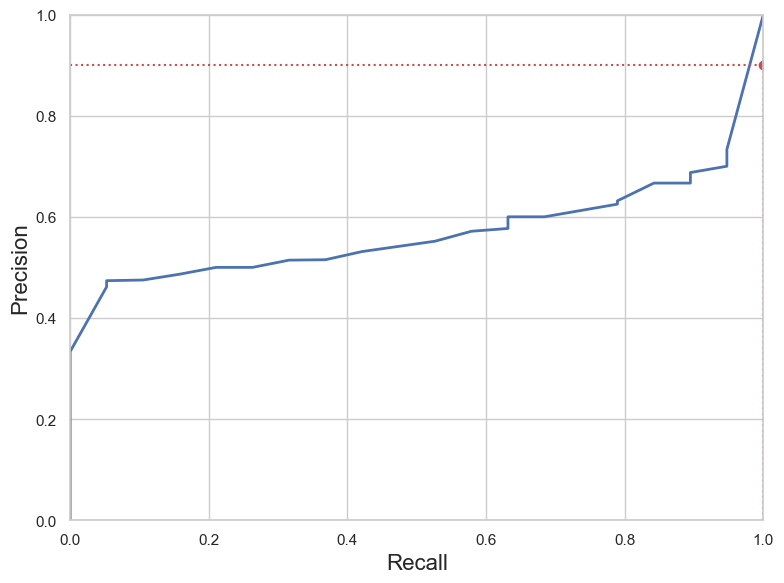

Saving figure Random_forest_classifier_roc_curve_ds1g


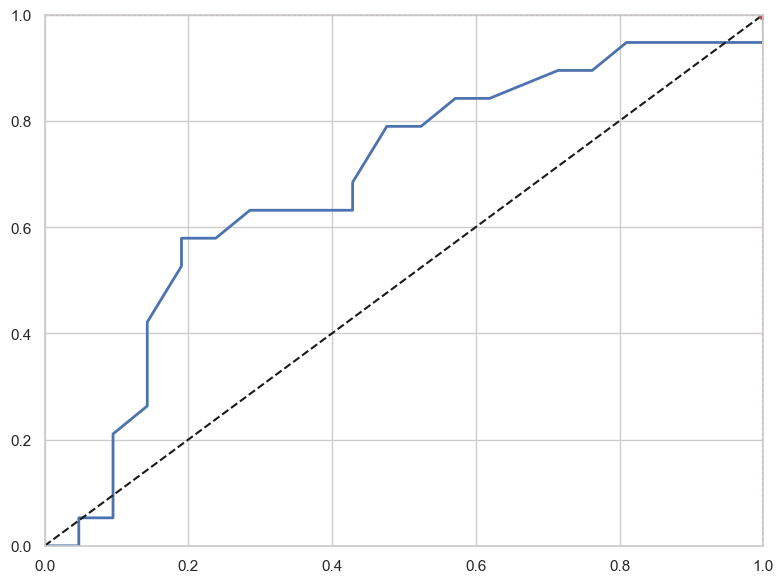

This is the roc_auc_score 0.6099744245524297


In [20]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
 
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    RFC = RandomForestClassifier()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('RFC', RFC)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "Random_forest_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "Random_forest_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


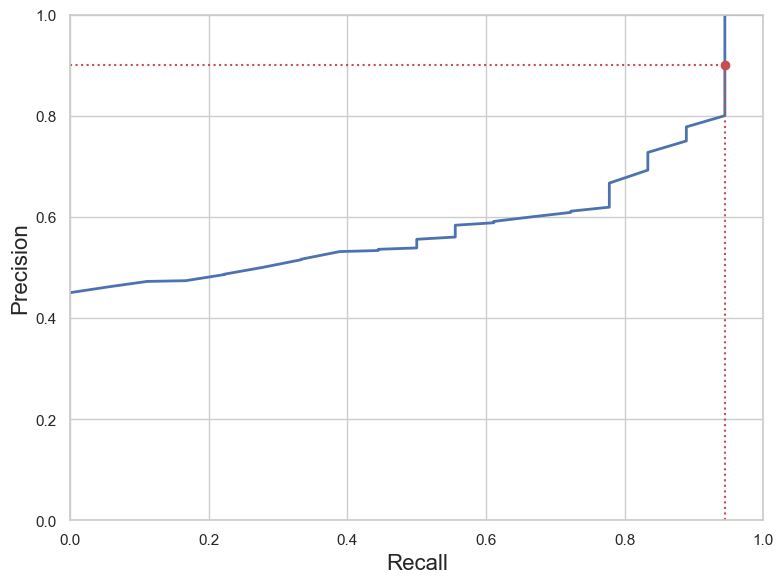

Saving figure MLP_neural_net_roc_curve_ds1a


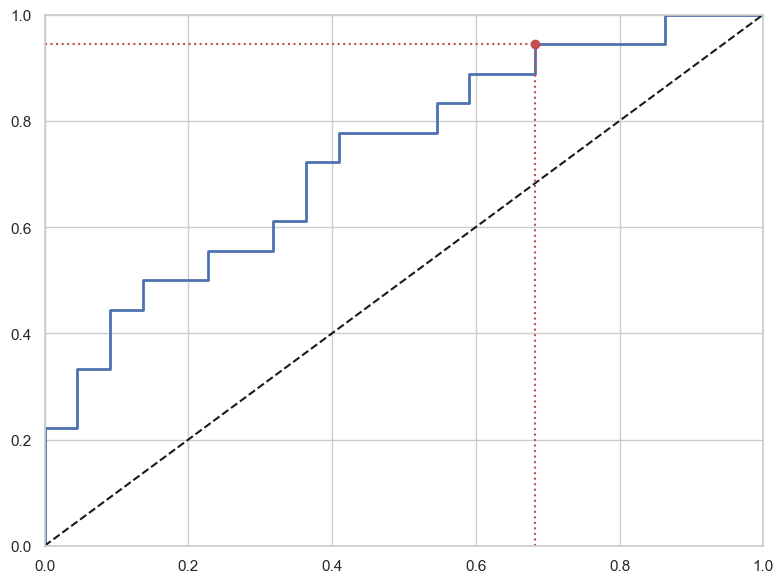

This is the roc_auc_score 0.7095959595959597
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

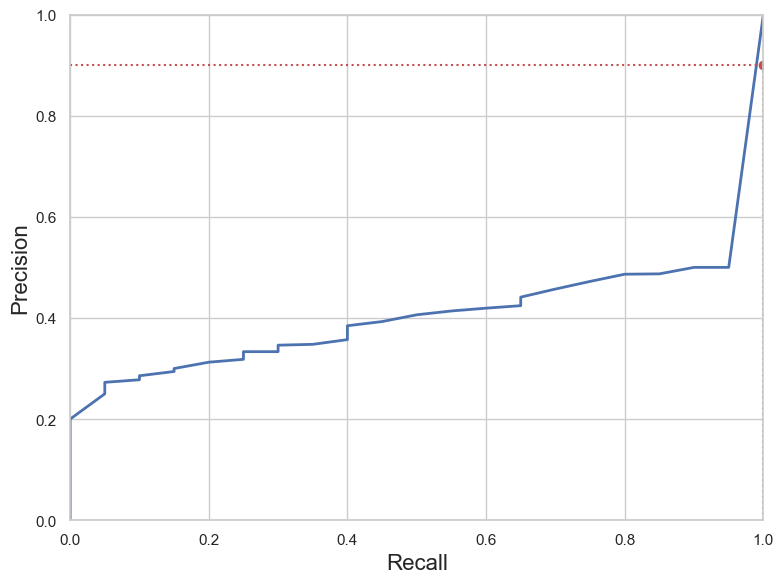

Saving figure MLP_neural_net_roc_curve_ds1b


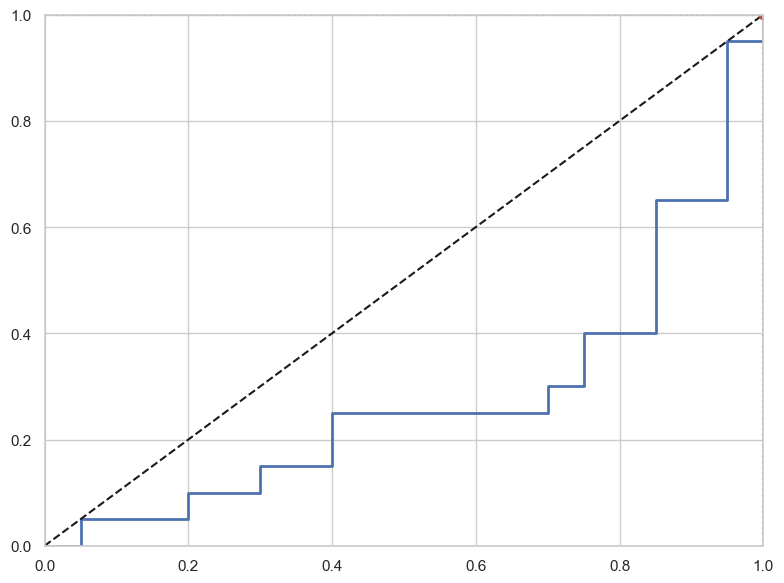

This is the roc_auc_score 0.4895833333333333
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


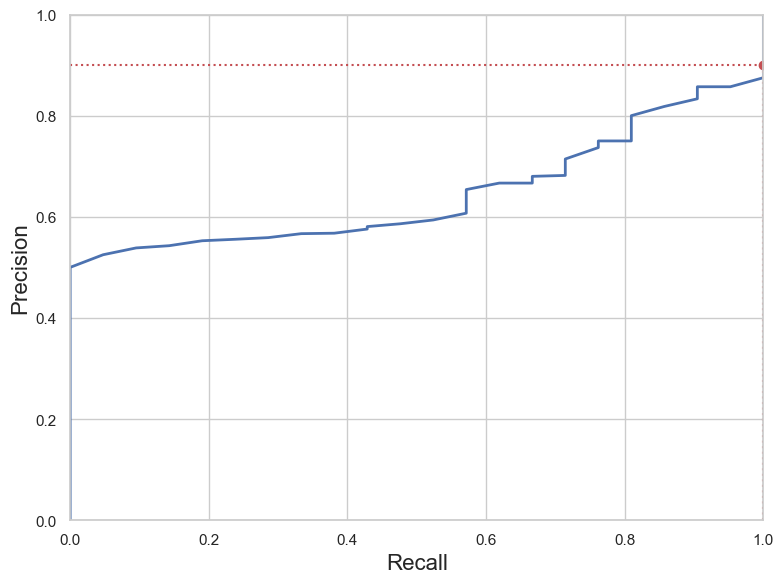

Saving figure MLP_neural_net_roc_curve_ds1f


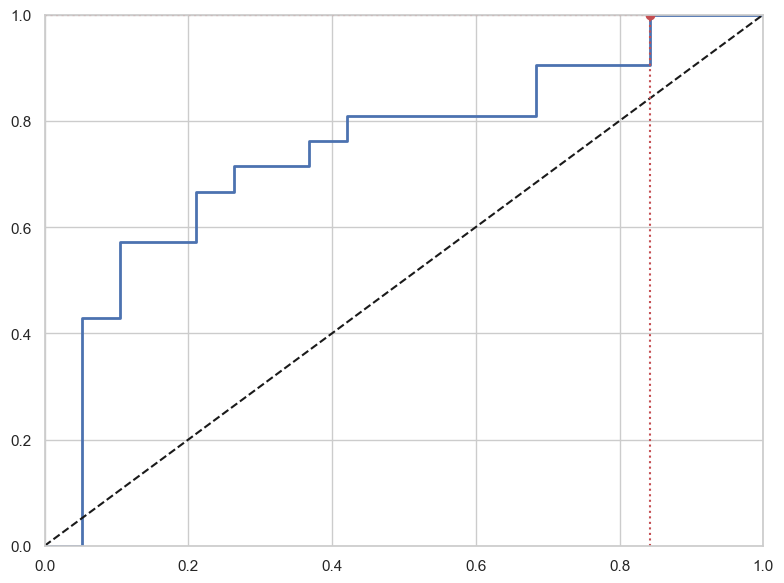

This is the roc_auc_score 0.6035353535353536
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


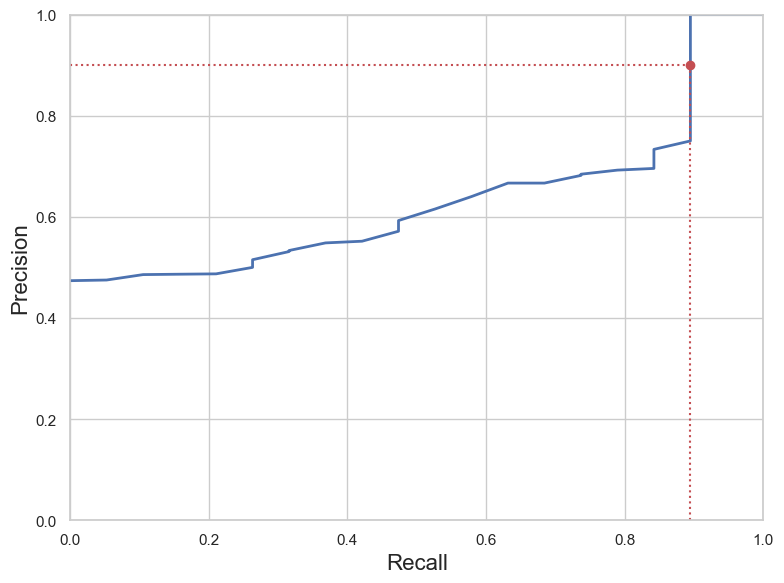

Saving figure MLP_neural_net_roc_curve_ds1g


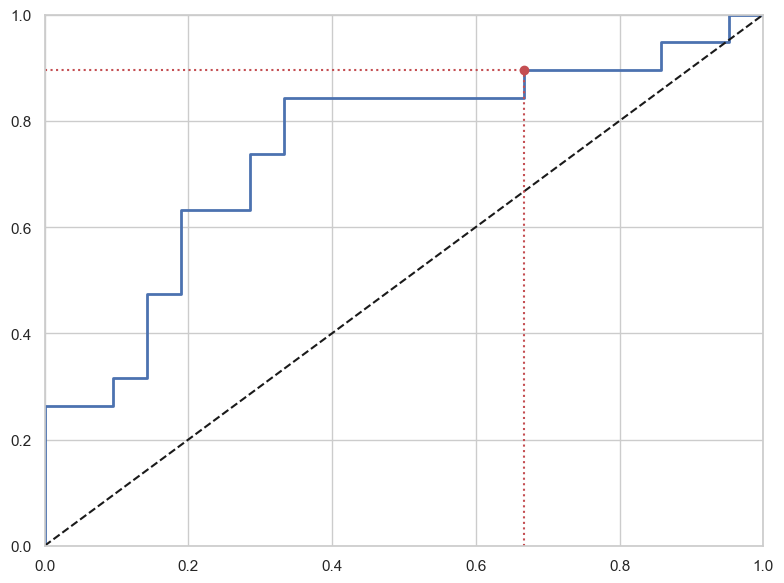

This is the roc_auc_score 0.8005115089514065


In [21]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the MLP neural net classifier
from sklearn.neural_network import MLPClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    

    # event_train = eventsTrain(fp[f])
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    MLP_C = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=42)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('MLP_C', MLP_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "MLP_neural_net_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "MLP_neural_net_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


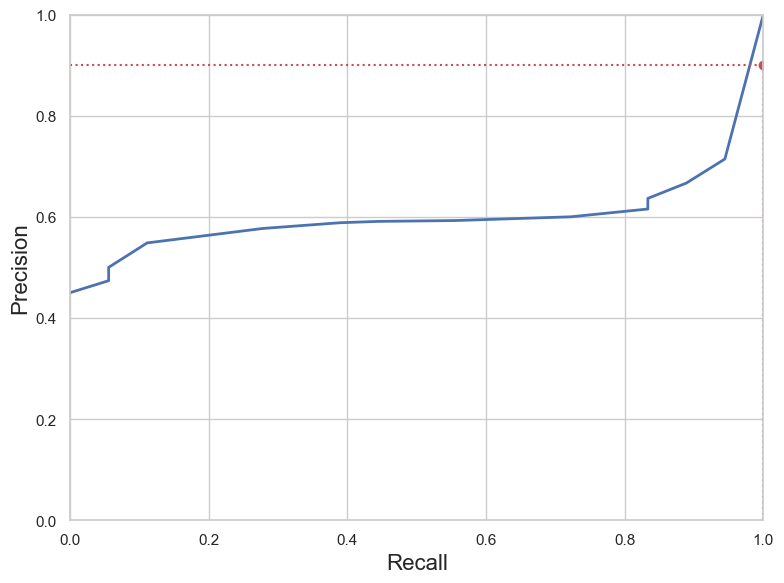

Saving figure KNN_classifier_roc_curve_ds1a


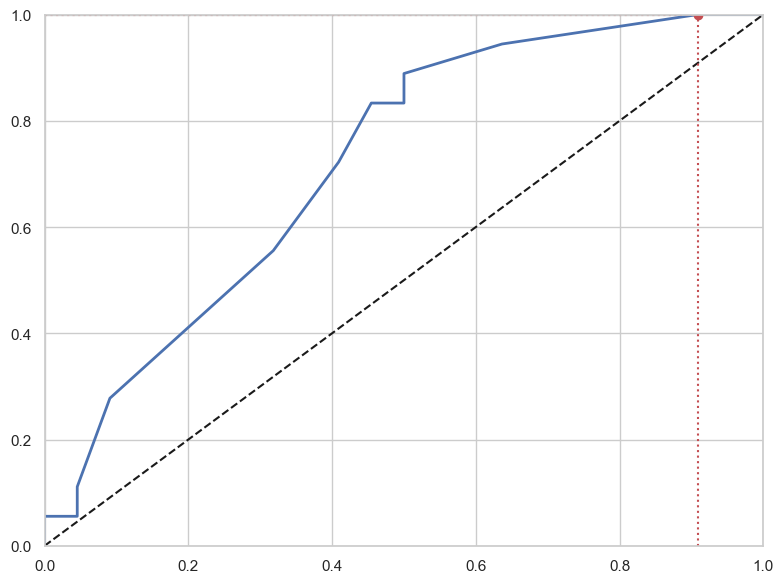

This is the roc_auc_score 0.7442455242966752
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

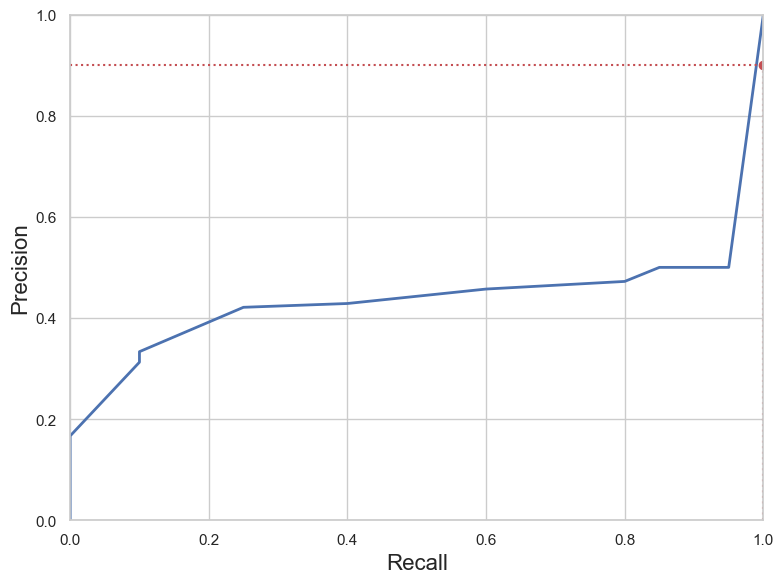

Saving figure KNN_classifier_roc_curve_ds1b


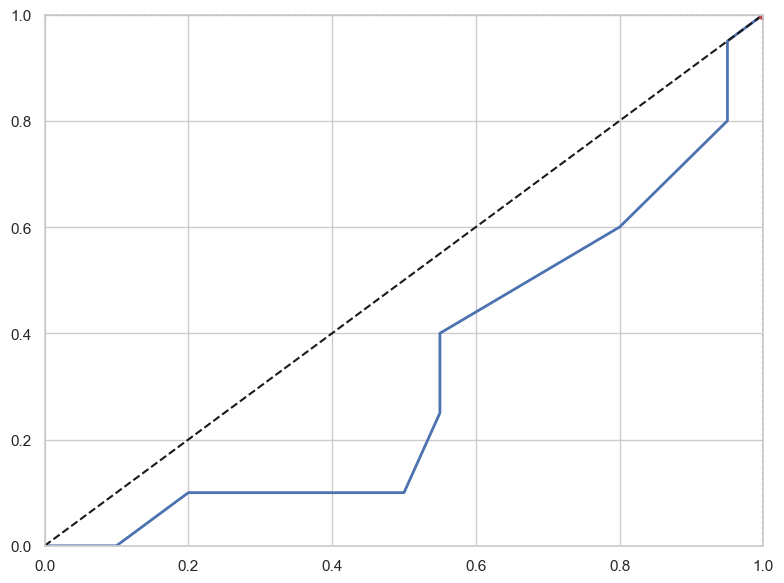

This is the roc_auc_score 0.5729166666666666
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.3s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


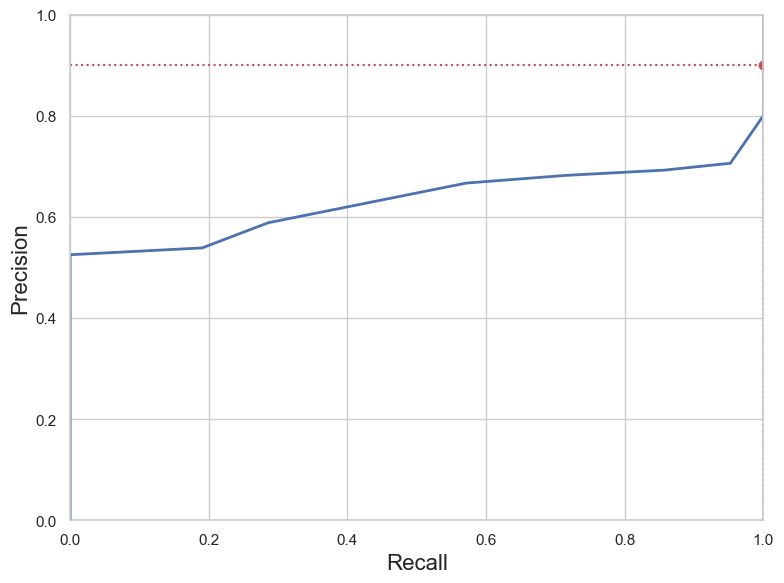

Saving figure KNN_classifier_roc_curve_ds1f


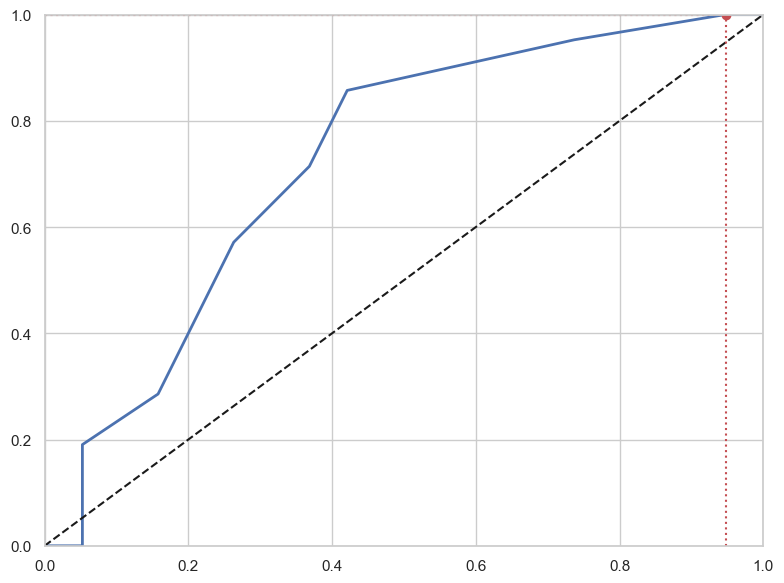

This is the roc_auc_score 0.6363636363636364
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


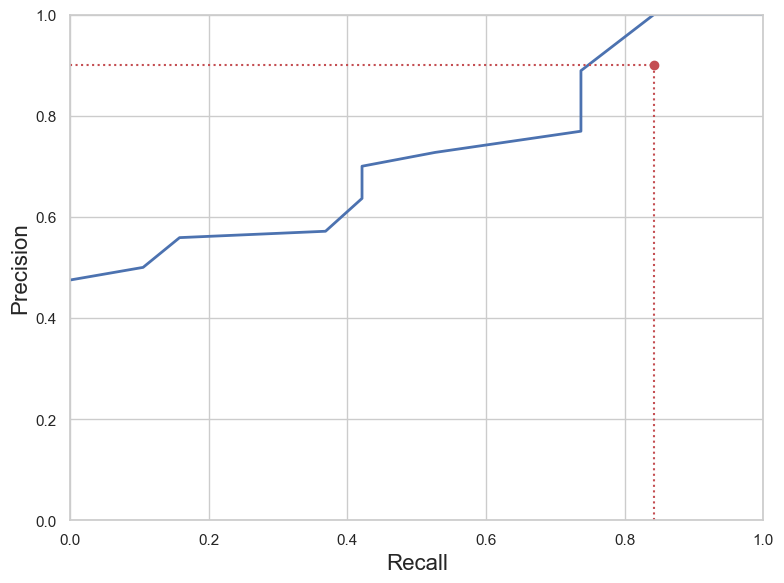

Saving figure KNN_classifier_roc_curve_ds1g


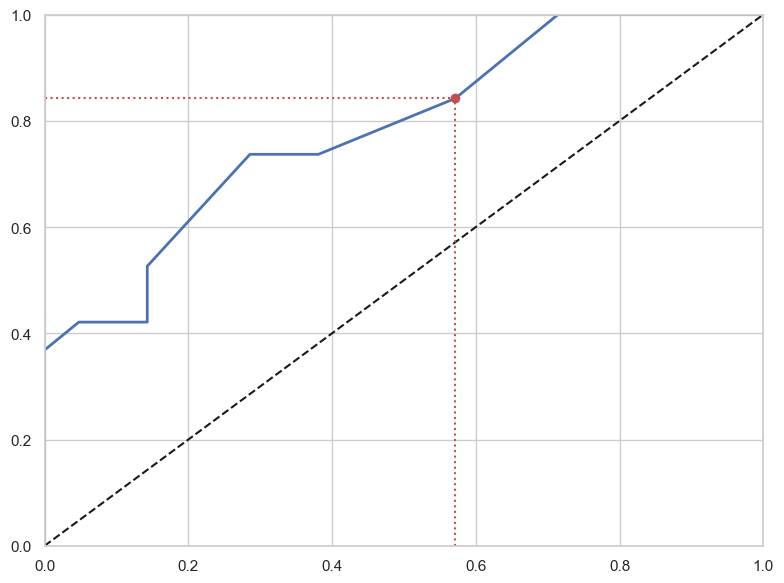

This is the roc_auc_score 0.7239583333333333


In [22]:
"""code reference from the mne documentation
https://www.researchgate.net/publication/321726030_The_Performance_Analysis_of_K-Nearest_Neighbors_K-NN_Algorithm_for_Motor_Imagery_Classification_Based_on_EEG_Signal

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

"""

#this is the Knearest neighbour classifier
from sklearn.neighbors import KNeighborsClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
        
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    KNN_C = KNeighborsClassifier(n_neighbors=15, algorithm='auto', n_jobs=1, metric='chebyshev')
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('KNN_C', KNN_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "KNN_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "KNN_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


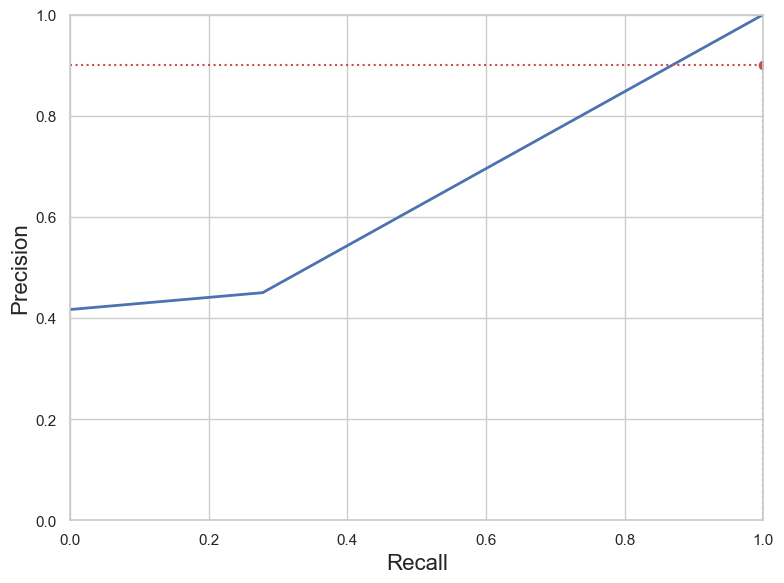

Saving figure Decision_tree_classifier_roc_curve_ds1a


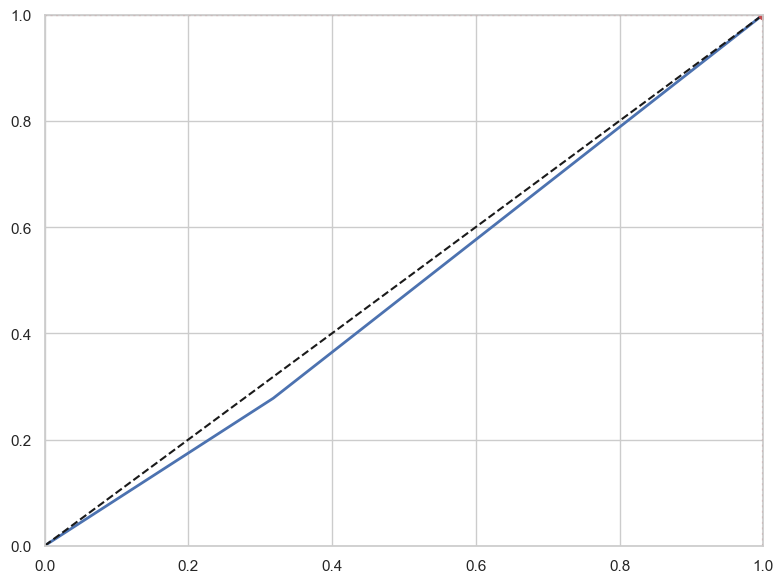

This is the roc_auc_score 0.4487179487179488
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

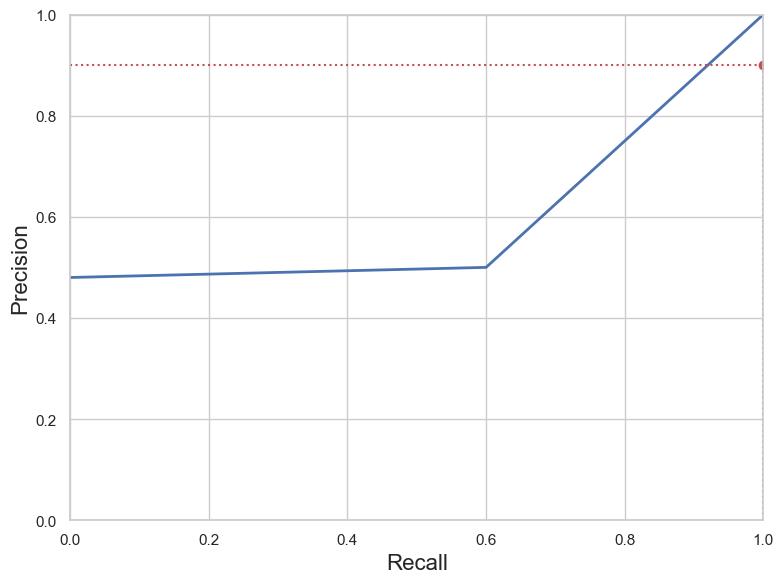

Saving figure Decision_tree_classifier_roc_curve_ds1b


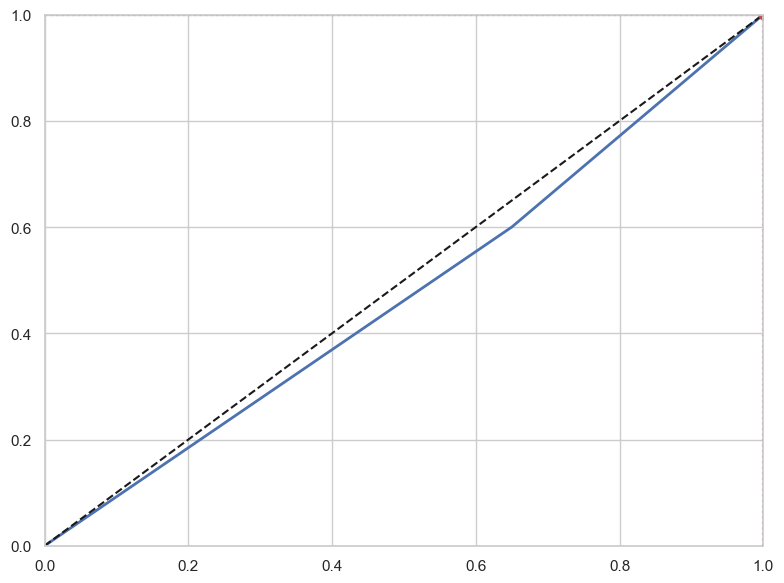

This is the roc_auc_score 0.475
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


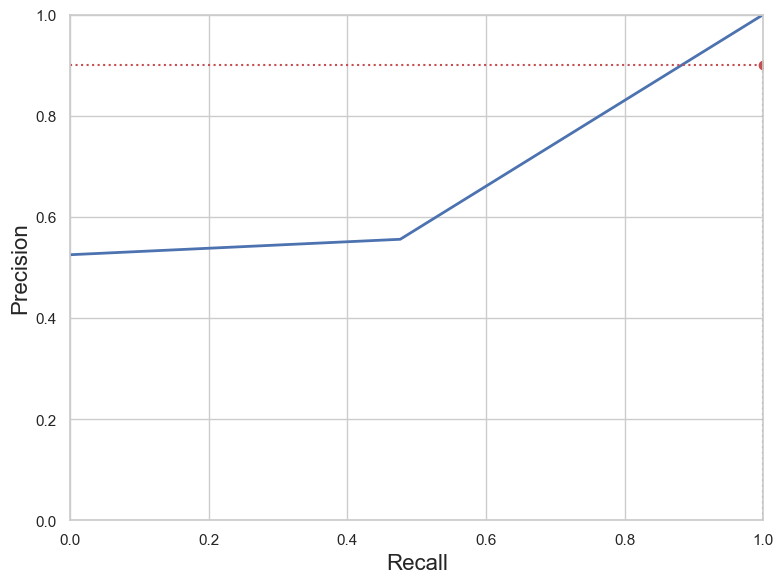

Saving figure Decision_tree_classifier_roc_curve_ds1f


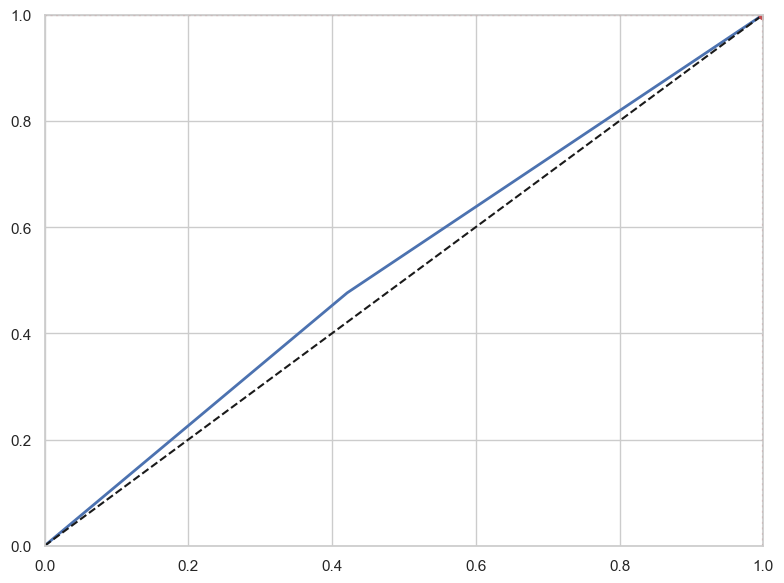

This is the roc_auc_score 0.4223057644110275
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


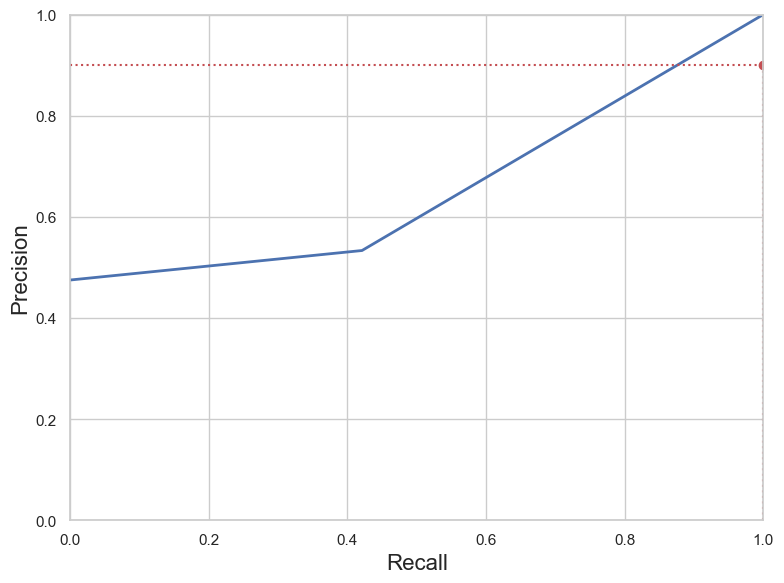

Saving figure Decision_tree_classifier_roc_curve_ds1g


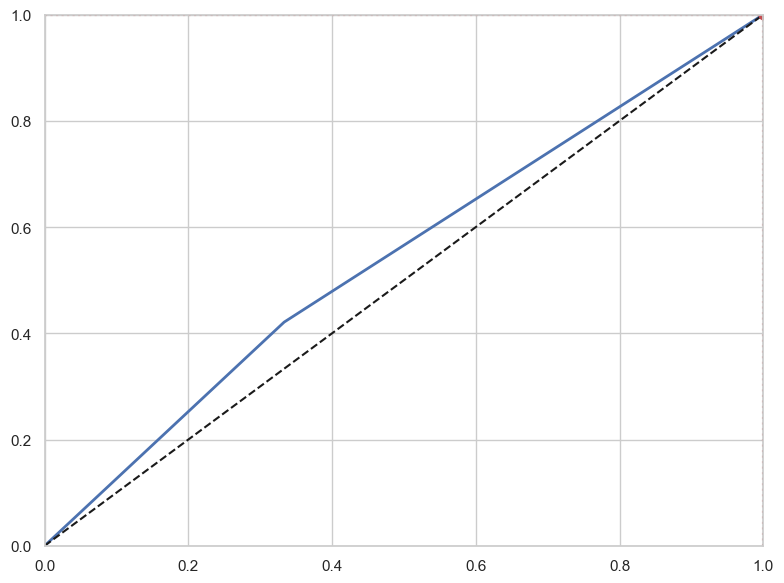

This is the roc_auc_score 0.5137362637362637


In [23]:
"""code reference from the mne documentation

"""

#this is the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')

    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    DTC = DecisionTreeClassifier(random_state=42, criterion='gini')
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('DTC', DTC)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "decision_tree_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "Decision_tree_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


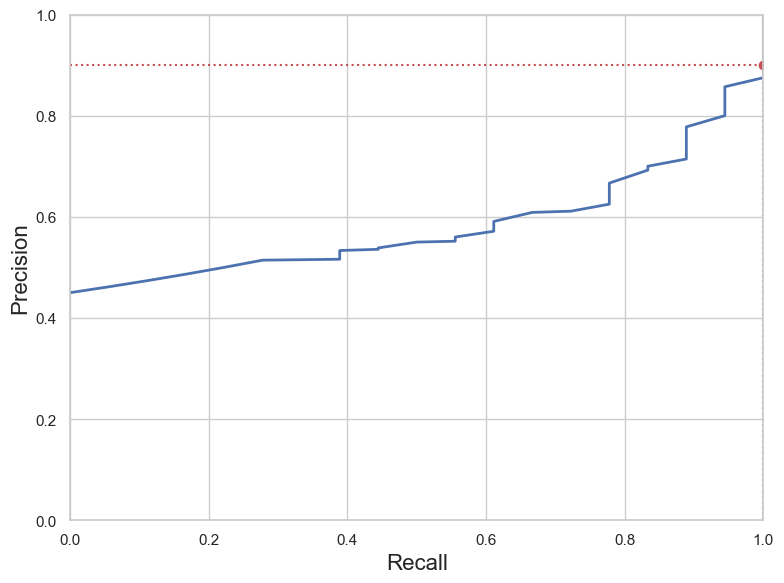

Saving figure logistic_regression_roc_curve_ds1a


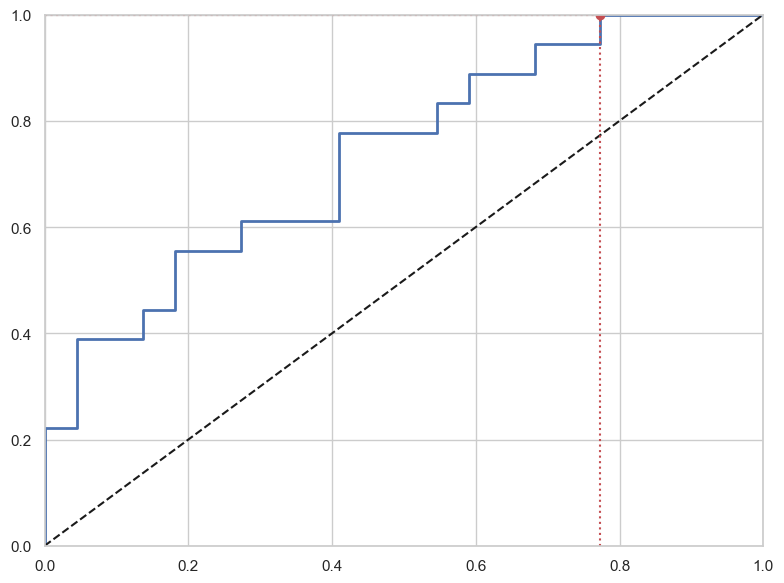

This is the roc_auc_score 0.7734375
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

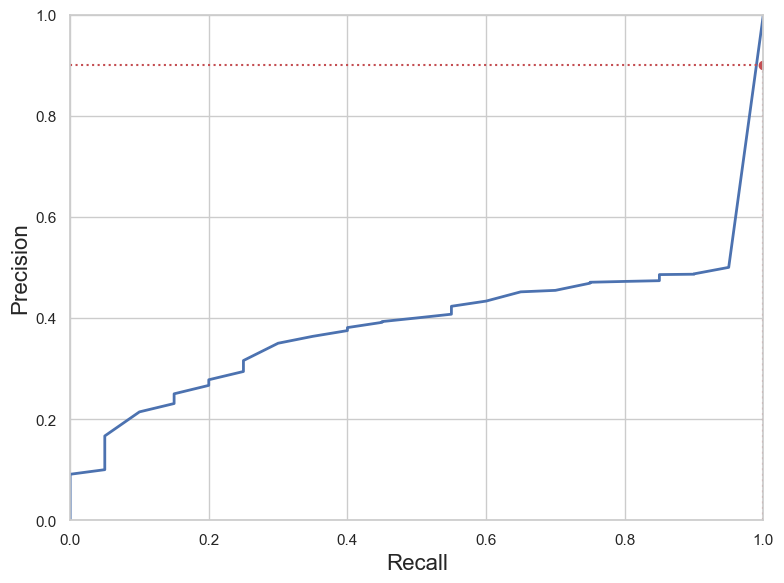

Saving figure logistic_regression_roc_curve_ds1b


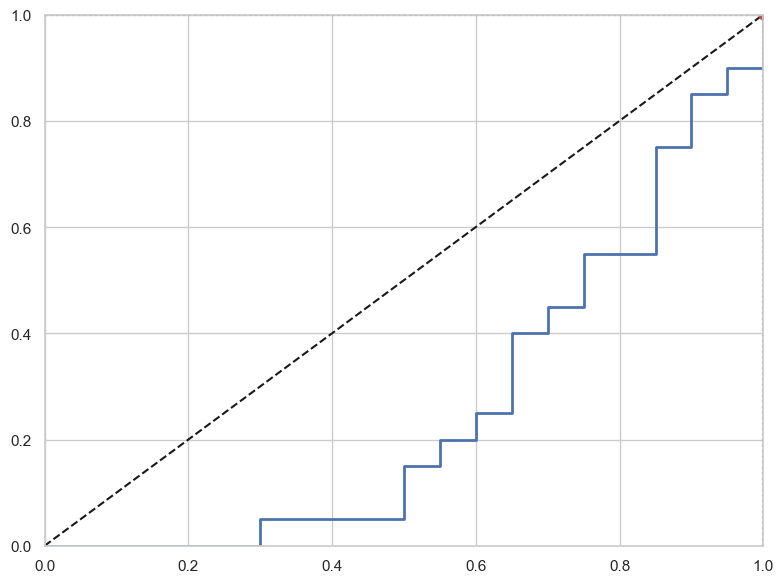

This is the roc_auc_score 0.6373626373626373
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


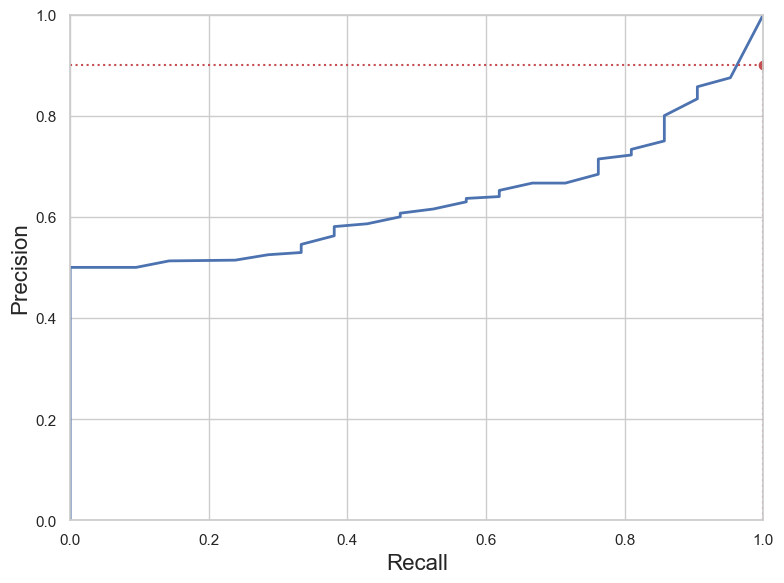

Saving figure logistic_regression_roc_curve_ds1f


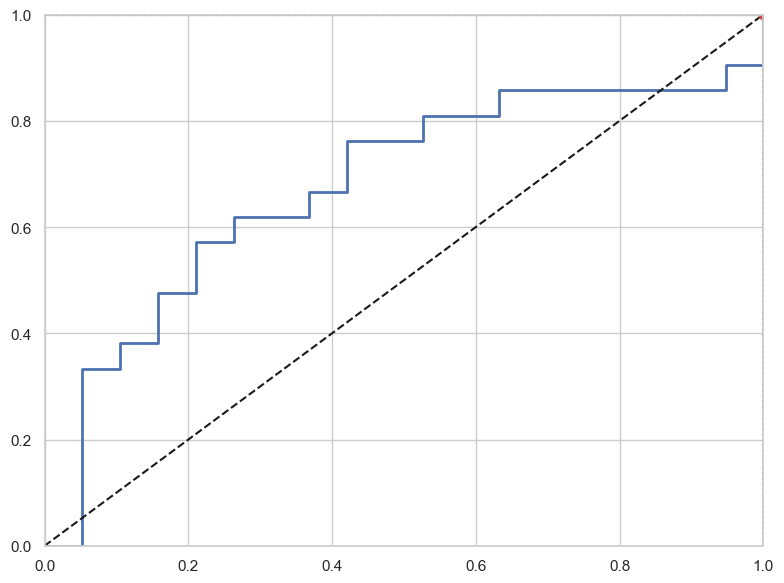

This is the roc_auc_score 0.7174999999999999
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


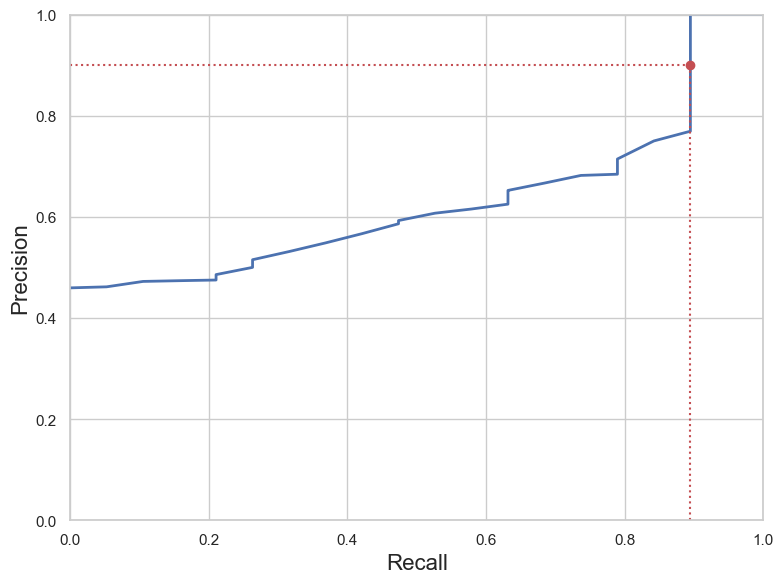

Saving figure logistic_regression_roc_curve_ds1g


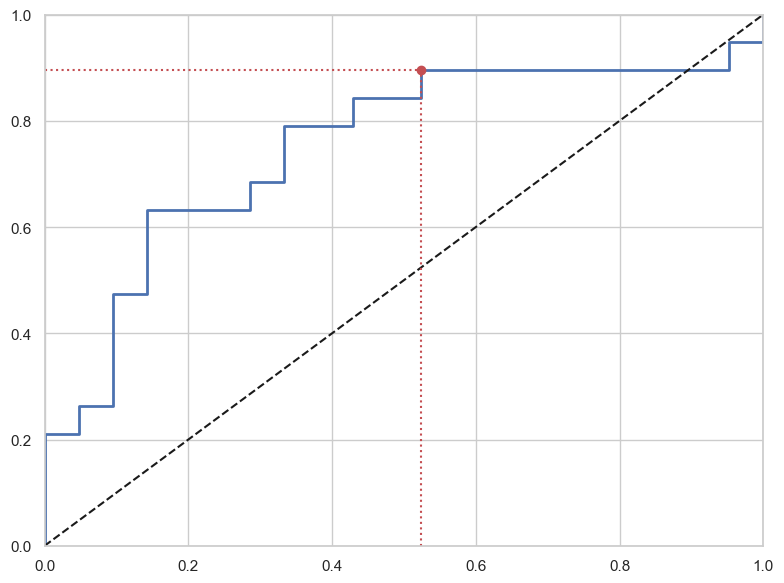

This is the roc_auc_score 0.75


In [24]:
"""code reference from the mne documentation

"""

#this is the Logistic regression
from sklearn.linear_model import LogisticRegression


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    LLR = LogisticRegression(random_state=42, penalty='l2', solver='lbfgs', verbose=0, n_jobs=1)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LLR', LLR)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_test_dfs = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='decision_function')

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "logistic_regression_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "logistic_regression_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


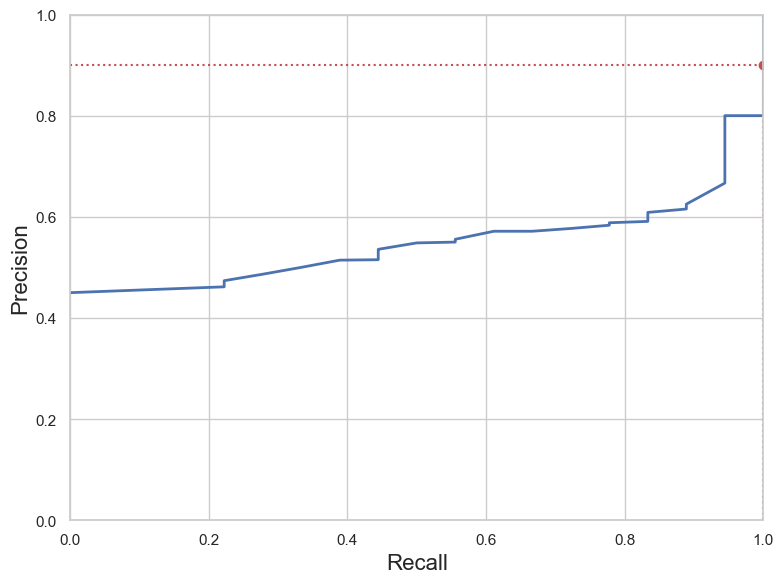

Saving figure GNB_classifier_roc_curve_ds1a


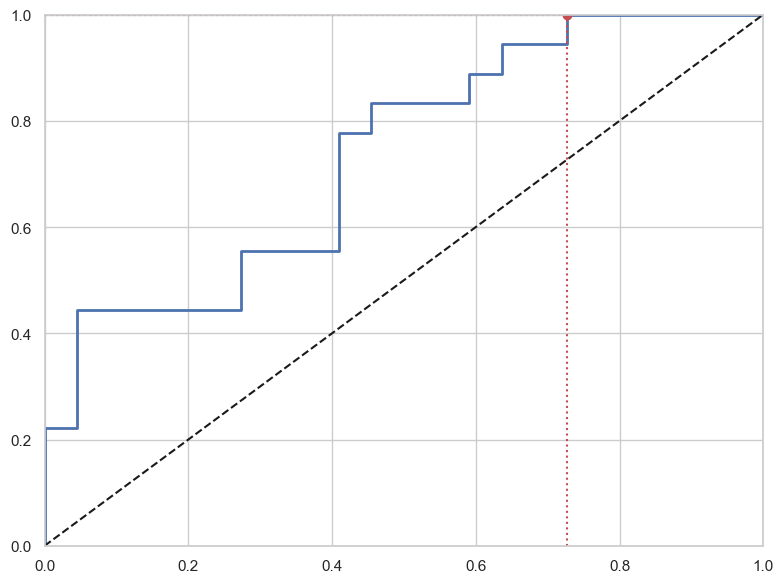

This is the roc_auc_score 0.74
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

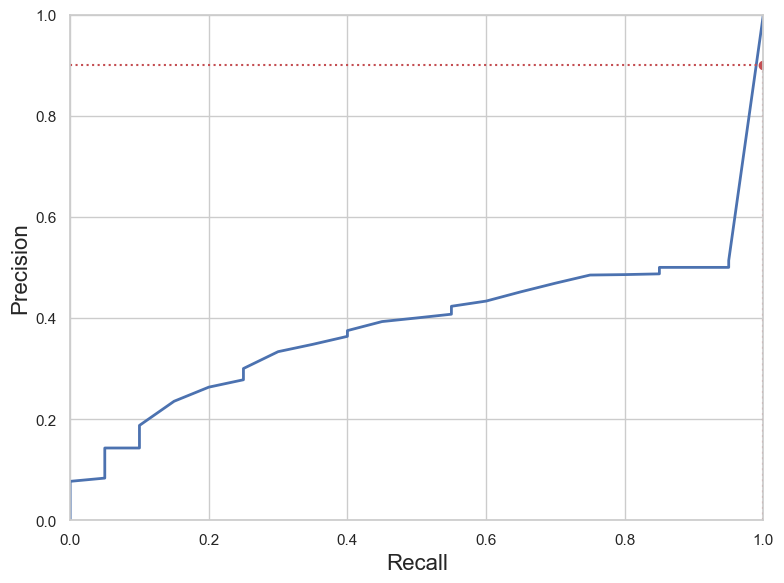

Saving figure GNB_classifier_roc_curve_ds1b


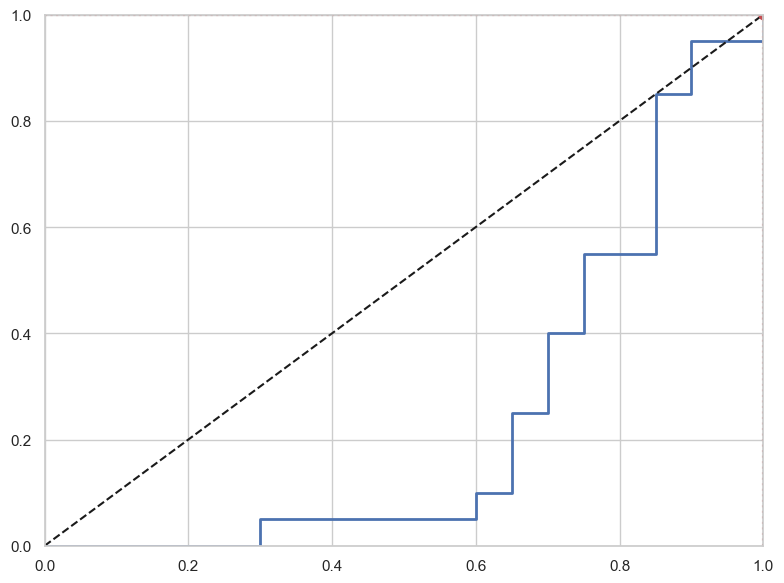

This is the roc_auc_score 0.5533333333333332
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


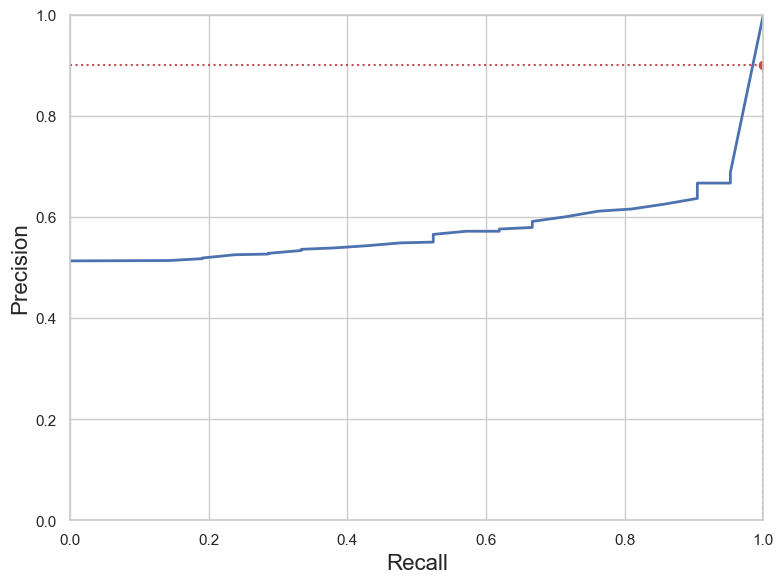

Saving figure GNB_classifier_roc_curve_ds1f


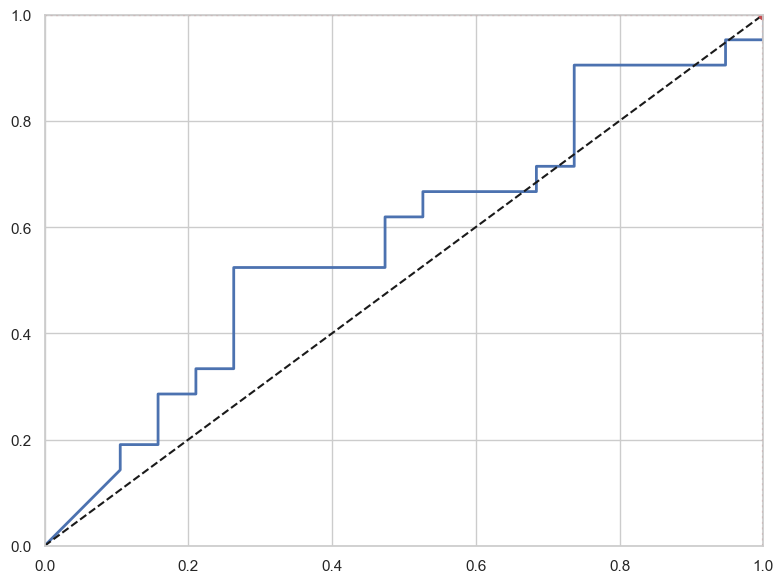

This is the roc_auc_score 0.5909090909090908
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


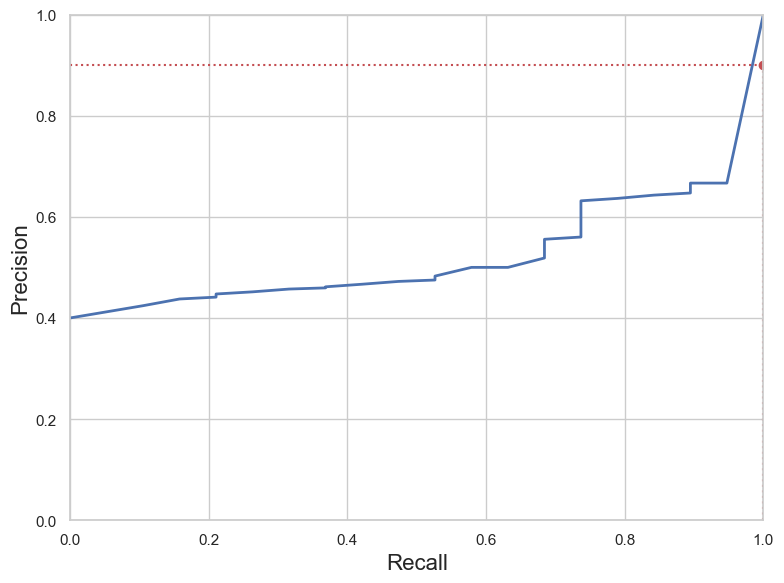

Saving figure GNB_classifier_roc_curve_ds1g


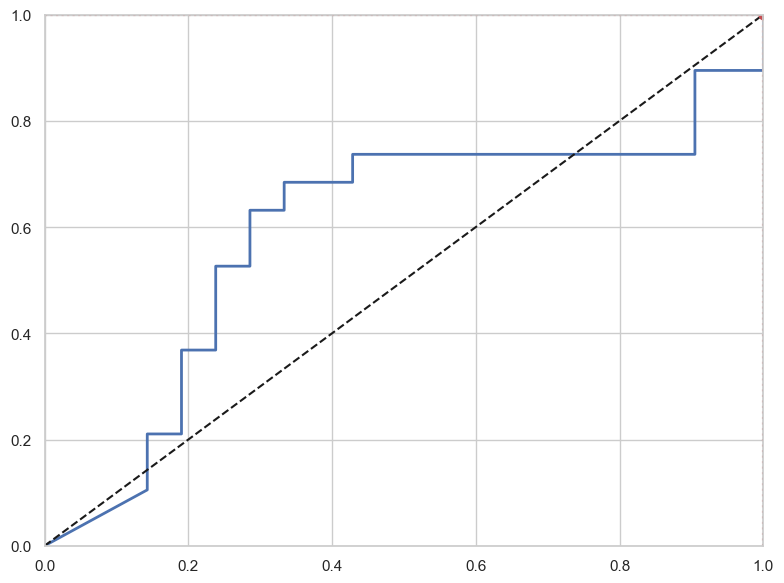

This is the roc_auc_score 0.6614583333333333


In [25]:
"""code reference from the mne documentation

"""

#this is the Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])
       
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    GNB = GaussianNB()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('GNB', GNB)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "GNB_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "GNB_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)

Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+03 (2.2e-16 eps * 59 dim * 1.7e+17  max singular value)


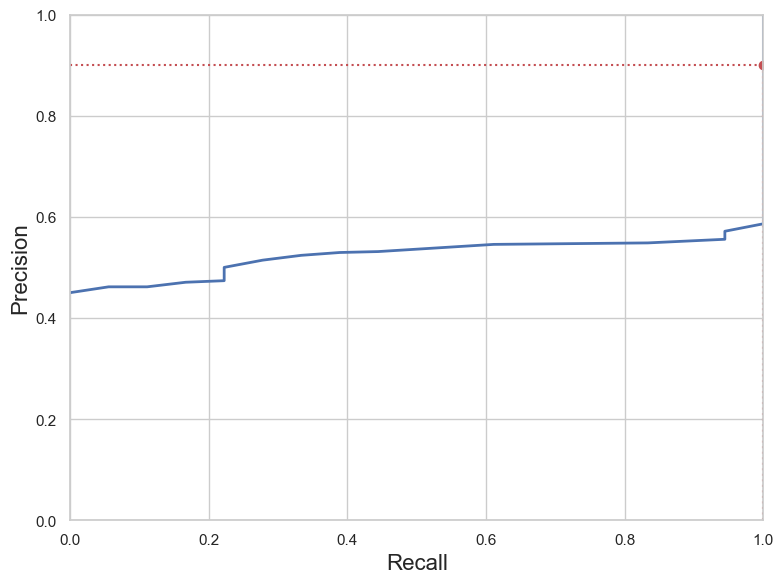

Saving figure BNB_classifier_roc_curve_ds1a


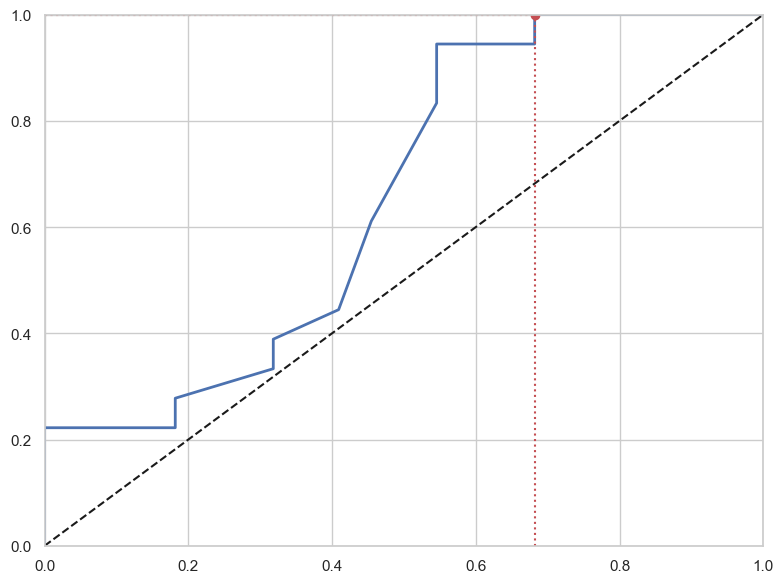

This is the roc_auc_score 0.819088319088319
Creating RawArray with float64 data, n_channels=59, n_times=1905940
    Range : 0 ... 1905939 =      0.000 ...  1905.939 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 5.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e+02 (2.2e-16 eps * 59 dim * 6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e+02 (2.2e-16 eps * 59 dim * 5.8e+16  max singular value)
  

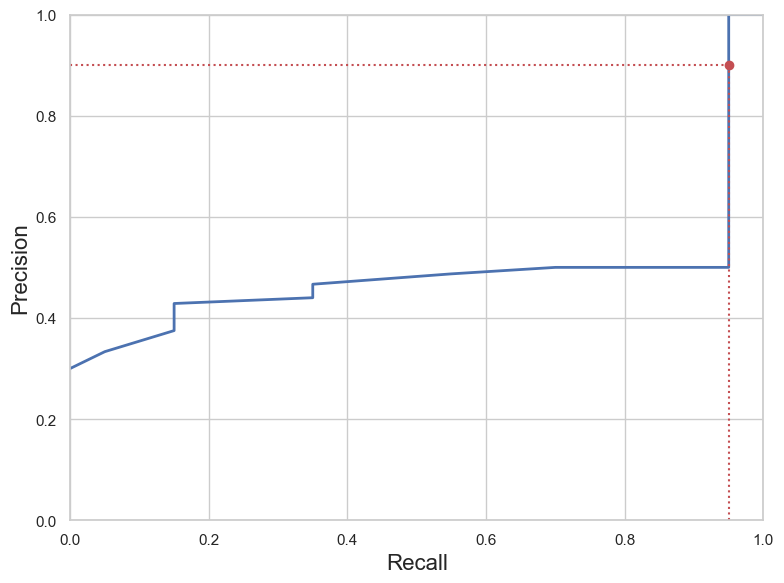

Saving figure BNB_classifier_roc_curve_ds1b


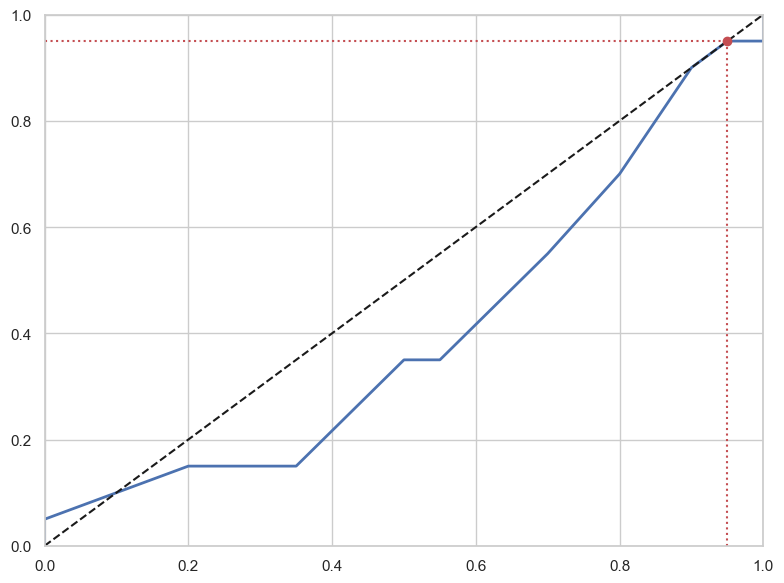

This is the roc_auc_score 0.31142857142857144
Creating RawArray with float64 data, n_channels=59, n_times=1906080
    Range : 0 ... 1906079 =      0.000 ...  1906.079 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 59 dim * 1.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+03 (2.2e-16 eps * 59 dim * 1.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 59 dim * 1.4e+17  max singular value)


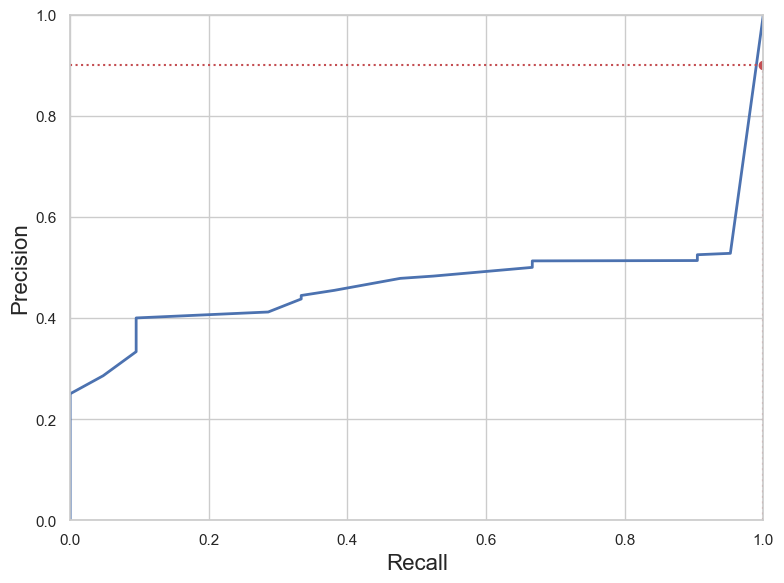

Saving figure BNB_classifier_roc_curve_ds1f


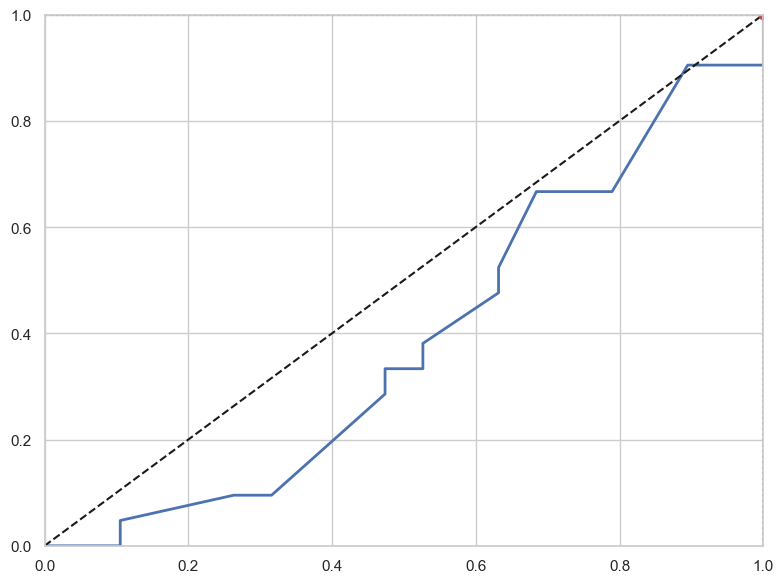

This is the roc_auc_score 0.475
Creating RawArray with float64 data, n_channels=59, n_times=1906020
    Range : 0 ... 1906019 =      0.000 ...  1906.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Computing rank from data with rank=None
    Using tolerance 3.8e+03 (2.2e-16 eps * 59 dim * 2.9e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e+03 (2.2e-16 eps * 59 dim * 3.4e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e+03 (2.2e-16 eps * 59 dim * 2.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 59 dim * 3.3e+17  max singular value)


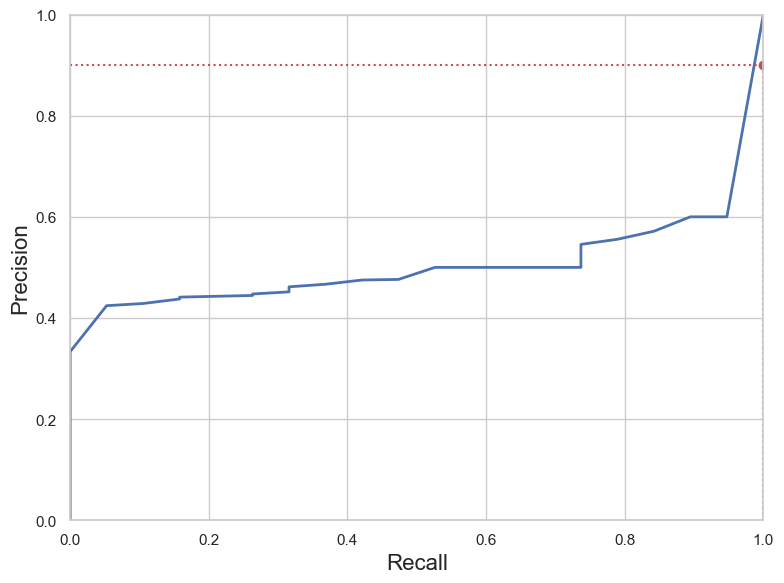

Saving figure BNB_classifier_roc_curve_ds1g


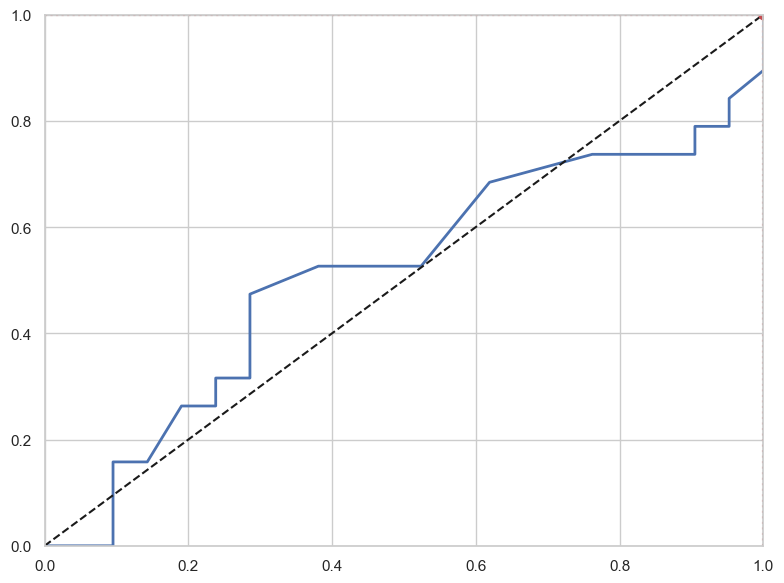

This is the roc_auc_score 0.3034188034188034


In [26]:
"""code reference from the mne documentation

"""

#this is the Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB


for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])    
    
    # Apply band-pass filter
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

    # Assemble a classifier
    BNB = BernoulliNB()
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('BNB', BNB)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
    
    print('---------------------------------------------------------------------------------------------------------')
    
    y_train_copy = y_train.copy()
    
    print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    
    clf.fit(X_train, y_train_copy)
    pred = clf.predict(X_test)
    rmse_train = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("rmse_train:",rmse_train)
    r2_train = float(format(clf.score(X_train, y_train_copy),'.3f'))
    print("r2_train:",r2_train)
    # ar2_train = float(format(adjustedR2(clf.score(X_train, y_train),X_train.shape[0],3),'.3f'))
    mae_train=float(format((metrics.mean_absolute_error(clf.predict(X_train), y_train_copy)),'.3f'))
    print("mae_train:",mae_train)
    print('---------------------------------------------------------------------------------------------------------')

    y_test_copy = y_test.copy()
    
    print(y_test)
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    print(y_test_copy)
    print('__________________________________________________________________________________')
    
    
    
    rmse_test = float(format(np.sqrt(metrics.mean_squared_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("rmse_test:",rmse_test)
    r2_test = float(format(clf.score(X_test, y_test_copy),'.3f'))
    print("r2_test:",r2_test)
    # ar2_test = float(format(adjustedR2(clf.score(X_test, y_test),X_test.shape[0],3),'.3f'))
    mae_test=float(format((metrics.mean_absolute_error(clf.predict(X_test), y_test_copy)),'.3f'))
    print("mae_test:",mae_test)
    print('---------------------------------------------------------------------------------------------------------')

    cv_train = float(format(cross_val_score(clf,X_train, y_train_copy,cv=5).mean(),'.3f'))
    print("cv_train:",cv_train)
    print('---------------------------------------------------------------------------------------------------------')

    cv_test = float(format(cross_val_score(clf,X_test, y_test_copy,cv=5).mean(),'.3f'))
    print("cv_test:",cv_test)
    print('---------------------------------------------------------------------------------------------------------')
    

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    #making the labels more generalized
    
    print('__________________________________________________________________________________')
    print(pred)
    
    #confusion matrix to know which class is being predicted
    print('__________________________________________________________________________')
    print('confusion matrix: ', confusion_matrix(y_test_copy, pred))
    print('__________________________________________________________________________')

#     print("precision_score",precision_score(pred, y_test_copy))
    print("precision_score",precision_score(y_test_copy, pred))
#     print("recall_score",recall_score(pred, y_test_copy))
    print("recall_score",recall_score(y_test_copy, pred))

#     print("f1_score",f1_score(pred, y_test_copy))
    print("f1_score",f1_score(y_test_copy, pred))
    
    
    
    
    #new territory from here
    y_probas = cross_val_predict(clf, X_test, y_test_copy, cv=5, method='predict_proba')
    
    y_test_dfs = y_probas[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test_copy, y_test_dfs)
    #precisions, recalls, thresholds = precision_recall_curve(y_test_copy, pred)

    print('precisions', precisions)
    precisions.sort()
    print('precisions1 -', precisions[-1])
    print('precisions0 - ', precisions[0])
    print('precisions', precisions.size)
    print('recalls', recalls)
    recalls.sort()
    print('recalls1 -', recalls[-1])
    print('recalls0 -', recalls[0])
    print('recalls', recalls.size)
    print('thresholds', thresholds)
    thresholds.sort()
    print('thresholds1 -', thresholds[-1])
    print('thresholds0 -', thresholds[0])
    print('thresholds', thresholds.size)
    
    #threshold precision recall graph
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    print(recall_90_precision)
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)-1]
    print(threshold_90_precision)


#     plt.figure(figsize=(8, 4))                                                                  
#     plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#     plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
#     plt.plot([-50, threshold_90_precision], [0.9, 0.9], "r:")                                
#     plt.plot([-50, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
#     plt.plot([threshold_90_precision], [0.9], "ro")                                           
#     plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           
#     plt.show()

    plt.figure(figsize=(8, 6))
    plot_precision_vs_recall(precisions, recalls)
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro")
    fig_name = "BNB_classifier_precision_vs_recall_"+ f
    save_fig(fig_name)
    plt.show()
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_copy, y_test_dfs)
    #fpr, tpr, thresholds = roc_curve(y_test_copy, pred)

    
    #plot curve
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax( tpr >= recall_90_precision)]
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([fpr_90], [recall_90_precision], "ro")
    fig_name = "BNB_classifier_roc_curve_"+ f
    save_fig(fig_name)
    plt.show()
    
    from sklearn.metrics import roc_auc_score
    print('This is the roc_auc_score', roc_auc_score(pred, y_test_dfs))
    #roc_auc_score(y_test_copy, pred)